In [1]:
import requests
import pandas as pd
from flatten_json import flatten
from utils.io import dict_to_yaml
from utils.io import yaml_to_dict
import numpy as np
from typing import List, Tuple, Dict, Union
from itertools import compress
import pandas as pd
import re
import datetime as dt
from cleanco import basename
from json import dumps
import matplotlib.pyplot as plt
import seaborn as sns

# from projects.lobbying.postproc import terms_present
import matplotlib.colors as mc

import warnings

warnings.filterwarnings("ignore")

id = "lgulden"
apikey = "4d1a4bc3be920e859b3862a25d3725d741028d42"
data_gov_api_key = "n4TEYUedn3STcnsxQi7JllzXZgfB6Dqg5pV2068E"
%load_ext jupyter_black

In [ ]:
config = yaml_to_dict(
    "/Users/lindseygulden/dev/leg-up-private/projects/lobbying/config_ccs_lda.yml"
)
term_list_dict = yaml_to_dict(config["search_term_list_path"])
law_list_dict = yaml_to_dict(
    "/Users/lindseygulden/dev/leg-up-private/projects/lobbying/ccs_laws.yml"
)

In [ ]:
authenticated_session = api_authenticate(
    config["authentication_endpoint"],
    config["lda_username"],
    config["lda_apikey"],
)
result = authenticated_session.get(
    config["filings_endpoint"],
    params={"filing_specific_lobbying_issues": f"{search_string}"},
)

In [2]:
def terms_present(phrase, term_list, find_any=True):
    """utility function to see if terms in terms_list are present in a given phrase
    Args:
        phrase: phrase to be searched
        term_list: list of strings to be searched for within phrase
        find_any: boolean -- true if function should return true if any of the terms are in the phrase;
            false if the function should only return true if all terms are present
    Returns:
        int: 1 if one or more of the terms are present in phrase, 0 otherwise
    """
    if not isinstance(phrase, str):
        raise TypeError("phrase must be a string")
    if not isinstance(term_list, list):
        raise TypeError(
            "term_list must be a list of strings (even if it is a list of length 1)"
        )
    if phrase is None:
        return 0
    n_present = 0

    for term in term_list:
        if isinstance(term, list):
            if terms_present(phrase, term, find_any=False):
                if find_any:
                    return 1
                n_present += 1
        elif term.lower() in phrase.lower():
            if find_any:
                return 1
            n_present += 1
    if n_present == len(term_list):
        return 1
    return 0


def get_list_govt_entities(entity_endpoint: str, session: object):
    """Queries constants endpoint to get a standardized list of government entities"""
    govt_entities = session.get(entity_endpoint, timeout=60)
    entity_df = pd.DataFrame(govt_entities.json())
    entities = sorted([x.lower() for x in list(entity_df["name"])])
    return entities


def api_authenticate(
    authentication_endpoint,
    username,
    apikey,
    username_key="username",
    password_key="password",
):
    """logs in to the api using provided authentication endpoint and credentials"""
    authenticated_session = requests.Session()

    authenticated_session.post(
        authentication_endpoint,
        json={
            username_key: username,
            password_key: apikey,
        },
        timeout=60,
    )

    return authenticated_session


def substitute(
    x: str,
    use_basename: bool = False,
    re_types: str = r"[^\w\s]",
    replace_str: str = "",
):
    """wrapper function for regular expression substitute funciton, linked with basename lib"""
    # use basename for company names
    if not isinstance(x, str):
        x = ""
    if use_basename:
        return basename(re.sub(re_types, replace_str, x))
    # don't use basename for general strings
    return re.sub(re_types, replace_str, x).rstrip().lstrip()


def parse_client_names(
    input_df, config, client_rename_col="client_rename"
) -> Tuple[pd.DataFrame, Dict[str, str]]:
    """bespoke function for parsing organization names from LDA queries
    Args:
        input_df: input pandas dataframe (read raw from files saved after api access)
        config: configuration dictionary containing details on how to handle names
        client_rename_column: name for new column in dataframe that is returned
    Returns:
        output_df: processed column with renamed clients and removed organziations
        client_name_rename_dict: dictionary used for renaming (contains original and new names)
    """
    output_df = input_df.copy(deep=True)

    starting_client_names = sorted(list(output_df.client_name.unique()))
    client_names = sorted(list(output_df.client_name.unique()))
    client_names = [
        substitute(company_name, use_basename=True) for company_name in client_names
    ]

    # take rightmost component of client name
    for term in config["take_terms_to_the_right_of_these_words"]:
        client_names = [x.split(term)[-1] for x in client_names]
    # take leftmost component of client name
    for term in config["take_terms_to_the_left_of_these_words"]:
        client_names = [x.split(term)[0] for x in client_names]
    # remove words
    for n in config["remove_these_phrases"]:
        client_names = [x.replace(n, "") for x in client_names]
    # get rid of double spaces
    client_names = [x.replace("  ", " ") for x in client_names]
    # trim spaces on ends of names
    client_names = [x.rstrip().lstrip() for x in client_names]

    # extract shorter, well-known names from longer names
    for co in config["use_these_name_subsets_for_organiztions"]:
        client_names = [co if co in x else x for x in client_names]

    # bespoke replacements and handling of mergers
    for key, value in config["replace_names_on_left_with_names_on_right"].items():
        client_names = [x.replace(key, value) for x in client_names]

    # make a renaming dictionary
    client_name_rename_dict = dict(zip(starting_client_names, client_names))

    # add the 'remove' companies to the rename dictionary
    remove_companies = config["remove_companies_containing_these_terms"]
    for x in client_name_rename_dict.keys():
        if terms_present(
            client_name_rename_dict[x],
            remove_companies,
            find_any=True,
        ):
            client_name_rename_dict[x] = "remove"

    # make new column with renames
    output_df[client_rename_col] = [
        client_name_rename_dict[x] for x in output_df.client_name
    ]
    output_df = output_df.loc[output_df[client_rename_col] != "remove"]

    return output_df, client_name_rename_dict


def get_smarties(
    row: Union[pd.Series, List[Union[bool, int]]], names: List[str]
) -> List[str]:
    if isinstance(row, pd.Series):
        return list(compress(names, row[names].values.tolist()))
    if isinstance(row, list):
        return list(compress(names, row))
    raise TypeError("get_smarties argument 'row' must be a Pandas Series or a list")


def get_latest_filings(
    df: pd.DataFrame, groupby_cols: List[str], date_col="filing_dt_posted"
):
    """get only the latest filing for a given lobbying firm, client, and quarter"""
    if df[date_col].dtype == str:
        df[date_col] = [dt.datetime.fromisoformat(d) for d in df[date_col]]

    df.sort_values(by=date_col, ascending=False, inplace=True)

    df = df.groupby(groupby_cols).first().reset_index()
    return df


def invert_sector_dict(sectors_path) -> Dict[str, str]:
    """reads in the sector assignment yaml to dict; inverts dict s.t. each company is a key"""
    sector_assignments = yaml_to_dict(sectors_path)

    all_companies = []
    for _, value in sector_assignments.items():
        all_companies = all_companies + value
    # print(all_companies)

    company_sector_dict = {}
    for k, vv in sector_assignments.items():
        for v in vv:
            company_sector_dict = company_sector_dict | {v: k}

    return company_sector_dict

In [3]:
config_info = yaml_to_dict(
    "/Users/lindseygulden/dev/leg-up-private/projects/lobbying/config_ccs_lda.yml"
)
groupby_cols = [
    "filing_year",
    "filing_period",
    "client_id",
    "registrant_id",
    "activity_id",
]
entities = get_list_govt_entities(
    config_info["entity_endpoint"],
    session=api_authenticate(
        config_info["authentication_endpoint"],
        config_info["lda_username"],
        config_info["lda_apikey"],
    ),
)
# remove_sector_descriptions = yaml_to_dict(
#    "/Users/lindseygulden/dev/leg-up-private/projects/lobbying/sector_company_description_terms.yml"
# )["remove"]
remove_sector_descriptions = yaml_to_dict(
    "/Users/lindseygulden/dev/leg-up-private/projects/lobbying/sector_descriptions.yml"
)["remove these organizations"]["keep"]
df_list = []
rename_dict = {}
for i in range(1, 5):  # 19):  # 159):
    api_results_df = pd.read_csv(
        # f"/Volumes/Samsung_T5/data/lobbying/ccslaws/ccs_lda_filings_{i}.csv",
        # f"/Volumes/Samsung_T5/data/lobbying/ccs/ccs_lda_filings_{i}.csv",
        f"/Volumes/Samsung_T5/data/lobbying/ccs_additional/ccs_lda_filings_{i}.csv",
        index_col=[0],
        # parse_dates=["filing_dt_posted"],
        dtype={"filing_year": int},
        low_memory=False,
    )
    # remove unwanted filing types
    api_results_df = api_results_df.loc[
        [x[0] != "R" for x in api_results_df.filing_type]
    ]

    # parse company names, remove unwanted names, add to list
    df, this_rename_dict = parse_client_names(
        api_results_df, yaml_to_dict(config_info["organization_name_handling_path"])
    )

    # append the rename dictionary to the whole thing
    rename_dict = rename_dict | this_rename_dict
    # compress entities into a single string column and get rid of entity columns
    df["entities"] = df[entities].T.apply(lambda x: dumps(get_smarties(x, entities)))
    df.drop(entities, axis=1, inplace=True)
    df["clean_description"] = [
        substitute(d, use_basename=True) for d in df["description"]
    ]
    df["clean_client_general_description"] = [
        substitute(d, use_basename=False) for d in df["client_general_description"]
    ]
    df["client_rename"] = [
        "remove" if terms_present(x, remove_sector_descriptions) else n
        for x, n in zip(df.clean_client_general_description, df.client_rename)
    ]
    df["client_rename"] = [
        "remove" if terms_present(x, remove_sector_descriptions) else x
        for x in df.client_rename
    ]

    df = get_latest_filings(df, groupby_cols)
    df = df.loc[df.client_rename != "remove"]
    df_list.append(df)

ccs_df = pd.concat(df_list)
ccs_df = get_latest_filings(ccs_df, groupby_cols)
# fill in nans/nones with empty string for description and rename of client
ccs_df.clean_client_general_description = (
    ccs_df.clean_client_general_description.fillna("")
)
ccs_df.client_rename = ccs_df.client_rename.fillna("")

ccs_df["batch"] = "additional"
ccs_df.to_csv("/Volumes/Samsung_T5/data/lobbying/ccs/ccs_additional_compiled.csv")
# ccs_df["batch"] = "ccs description and/or ccs specific laws and bills"
# ccs_df.to_csv("/Volumes/Samsung_T5/data/lobbying/ccs/ccs_compiled.csv")
# ccs_df["batch"] = "relevant laws"
# ccs_df.to_csv("/Volumes/Samsung_T5/data/lobbying/ccs/ccslaws_compiled.csv")

In [6]:
# join different query results into a single dataframe
tmp_df = pd.read_csv("/Volumes/Samsung_T5/data/lobbying/ccs/ccs_compiled.csv")
law_df = pd.read_csv("/Volumes/Samsung_T5/data/lobbying/ccs/ccslaws_compiled.csv")
additional_df = pd.read_csv(
    "/Volumes/Samsung_T5/data/lobbying/ccs/ccs_additional_compiled.csv"
)
ccs_df = pd.concat([tmp_df, law_df, additional_df])
ccs_df.sort_values(by=["batch"], ascending=True, inplace=True)
ccs_df.drop_duplicates(
    subset=["filing_uuid", "activity_id"], keep="first", inplace=True
)
ccs_df.reset_index(inplace=True)
# write out updated, merged, slightly processed ccsall
ccs_df.clean_client_general_description = (
    ccs_df.clean_client_general_description.fillna("")
)
ccs_df.client_rename = ccs_df.client_rename.fillna("")
ccs_df.to_csv("/Volumes/Samsung_T5/data/lobbying/ccs/ccsall_compiled.csv")

In [5]:
ccs_df = pd.read_csv(
    #    "/Volumes/Samsung_T5/data/lobbying/ccs/ccsall_compiled.csv", index_col=[0]
    "/Volumes/Samsung_T5/data/lobbying/ccs/ccsall_compiled_revised.csv",
    index_col=[0],
)
ccs_df.clean_client_general_description = (
    ccs_df.clean_client_general_description.fillna("")
)
ccs_df.client_rename = ccs_df.client_rename.fillna("")

In [7]:
description_dict = yaml_to_dict("sector_descriptions.yml")
sector_list = sorted(list(description_dict.keys()))

In [8]:
sectors_dict = yaml_to_dict(
    "/Users/lindseygulden/dev/leg-up-private/projects/lobbying/sectors_updated.yml"
)
inverted_sector_dict = invert_sector_dict(
    "/Users/lindseygulden/dev/leg-up-private/projects/lobbying/sectors_updated.yml"
)
companies = [c.rstrip().lstrip() for c in list(inverted_sector_dict.keys())]

# Review specific industry details/data

In [ ]:

which_sector = "oil and gas"  # "auto and transportation"  # "renewable energy"  # "chemicals"  # "cement"  # "engineering, technology, and consulting"  # "nuclear"  # "remove these organizations"
sectors_dict = yaml_to_dict(
    "/Users/lindseygulden/dev/leg-up-private/projects/lobbying/sectors.yml"
)
inverted_sector_dict = invert_sector_dict(
    "/Users/lindseygulden/dev/leg-up-private/projects/lobbying/sectors.yml"
)
companies = [c.rstrip().lstrip() for c in list(inverted_sector_dict.keys())]
description_dict = yaml_to_dict("sector_descriptions.yml")
sector_list = sorted(list(description_dict.keys()))
org_names = []
companies_list = companies  # list(inverted_sector_dict.keys())
for n, row in ccs_df.iterrows():
    phrase = row["clean_client_general_description"].lower()
    client_rename = row["client_rename"].lower()
    if row["client_rename"] in companies:
        pass
    elif terms_present(
        phrase, description_dict[which_sector]["exclude"], find_any=True
    ):
        pass
    elif terms_present(
        client_rename,
        description_dict[which_sector]["exclude"],
        find_any=True,
    ):
        pass
    elif terms_present(phrase, description_dict[which_sector]["keep"], find_any=True):
        org_names.append((row["client_rename"]))
    elif terms_present(
        client_rename, description_dict[which_sector]["keep"], find_any=True
    ):
        org_names.append((row["client_rename"]))
org_list = sorted(list(set(org_names)))
for i in org_list:
    if i.rstrip().lstrip() in companies:
        pass
    else:
        # print(f"- {i}")
        print(f"'{i}',")

In [ ]:
sectors_dict = yaml_to_dict(
    "/Users/lindseygulden/dev/leg-up-private/projects/lobbying/sectors_updated.yml"
)
inverted_sector_dict = invert_sector_dict(
    "/Users/lindseygulden/dev/leg-up-private/projects/lobbying/sectors_updated.yml"
)
companies = [c.rstrip().lstrip() for c in list(inverted_sector_dict.keys())]
not_assigned = sorted(list(set(ccs_df.client_rename.unique()) - set(companies)))

# for c in not_assigned:
# if (term in c.lower()) | (any([term in x.lower() for x in descriptions])):
#    print(f"'{c}',")
#    print(descriptions)

In [ ]:
for c in not_assigned:
    original_names = ccs_df.loc[ccs_df.client_rename == c].client_name.unique()
    for n in original_names:
        print(f"{n}: {c}")

In [ ]:
sectors_dict = yaml_to_dict(
    "/Users/lindseygulden/dev/leg-up-private/projects/lobbying/sectors.yml"
)
for k, v in sectors_dict.items():
    sectors_dict[k] = sorted(list(set(v)))

dict_to_yaml(
    sectors_dict,
    "/Users/lindseygulden/dev/leg-up-private/projects/lobbying/sectors_2.yml",
)

In [ ]:
sectors_dict = yaml_to_dict(
    "/Users/lindseygulden/dev/leg-up-private/projects/lobbying/sectors.yml"
)
inverted_sector_dict = invert_sector_dict(
    "/Users/lindseygulden/dev/leg-up-private/projects/lobbying/sectors.yml"
)
companies = [c.rstrip().lstrip() for c in list(inverted_sector_dict.keys())]
not_assigned = sorted(list(set(ccs_df.client_rename.unique()) - set(companies)))

list_of_companies = org_list
list_of_companies = not_assigned
# list_of_companies = sorted(list(set(sectors_dict[which_sector])))
for org in list_of_companies:
    descriptions = list(
        ccs_df.loc[
            ccs_df.client_rename == org
        ].clean_client_general_description.unique()
    )
    term = "flight"
    if (term in org.lower()) | any([term in x for x in descriptions]):
        print(f"- {org}")
        print(descriptions)

#  IDENTIFY CCS LOBBYING ACTIVITIES

In [48]:
portland_replace_dict = yaml_to_dict(
    "/Users/lindseygulden/dev/leg-up-private/projects/lobbying/company_name_replacements.yml"
)

ccs_df["client_rename"] = [
    portland_replace_dict[x] if x in list(portland_replace_dict.keys()) else r
    for x, r in zip(ccs_df.client_name, ccs_df.client_rename)
]
dict_to_yaml(portland_replace_dict, "company_name_replacements.yml")

In [49]:
sector_descriptions_dict = yaml_to_dict(
    "/Users/lindseygulden/dev/leg-up-private/projects/lobbying/sector_company_description_terms.yml"
)
sector_mapping = yaml_to_dict(
    "/Users/lindseygulden/dev/leg-up-private/projects/lobbying/sectors_updated.yml"
)
mapped_orgs = []
for v in sector_mapping.values():
    mapped_orgs = mapped_orgs + v

In [50]:
search_term_dict = yaml_to_dict(
    "/Users/lindseygulden/dev/leg-up-private/projects/lobbying/search_term_list.yml"
)

search_terms = search_term_dict["search_term_list"]
probably_ccs = search_term_dict["probably_ccs"]
maybe_ccs = search_term_dict["maybe_ccs"]
not_ccs = search_term_dict["not_ccs"]

terms = []
for t in search_terms:
    if "," in t:
        terms.append(t.replace('"', "").split(","))
    else:
        terms.append([t.replace('"', "")])

# terms = [[substitute(t) for t in tt] for tt in terms]

single_terms = []
multiple_terms = []
for x in terms:
    if len(x) == 1:
        single_terms.append(x[0])
    else:
        multiple_terms.append(x)

# get names of CCS bills
ccs_bills = yaml_to_dict(
    "/Users/lindseygulden/dev/leg-up-private/projects/lobbying/ccs_laws.yml"
)["mostly_ccs_provisions"]
ccs_bills = [re.sub(r"[^\w\s]", "", x) for x in ccs_bills]

In [51]:
df = ccs_df.copy(deep=True)

In [52]:
sectors = list(
    yaml_to_dict(
        "/Users/lindseygulden/dev/leg-up-private/projects/lobbying/sectors_updated.yml"
    ).keys()
)

In [53]:
inverted_sector_dict = invert_sector_dict(
    "/Users/lindseygulden/dev/leg-up-private/projects/lobbying/sectors_updated.yml"
)
lumped_sector_dict = yaml_to_dict(
    "/Users/lindseygulden/dev/leg-up-private/projects/lobbying/lumped_sectors.yml"
)
df["sector"] = [inverted_sector_dict[x] for x in df.client_rename]
df["lumped_sector"] = [lumped_sector_dict["lightly_lumped"][s] for s in df.sector]
df["very_lumped_sector"] = [lumped_sector_dict["very_lumped"][s] for s in df.sector]

In [54]:
# get rid of nans
df.clean_description = df.clean_description.fillna(" ")

# is ccs described in the lobbying description? (intermediate variables)
df["ccs_single"] = [terms_present(x, single_terms) for x in df.clean_description]
df["ccs_multiple"] = [
    any([terms_present(x, y, find_any=False) for y in multiple_terms])
    for x in df.clean_description
]
df["contains_ccs_description"] = [
    max(sgl, dbl) for sgl, dbl in zip(df["ccs_single"], df["ccs_multiple"])
]
# is this a company dedicated to CCS tech and operations?
df["ccs_company"] = [1 if x == "ccs" else 0 for x in df.sector]

# is a ccs bill directly mentioned?
df["ccs_bills"] = [terms_present(x, ccs_bills) for x in df.clean_description]

# are some of the terms that negate it being likely ccs present?
df["not_ccs"] = [terms_present(x, not_ccs) for x in df.clean_description]

# are terms that indicate this is probably ccs present?
df["terms_probably_ccs"] = [
    terms_present(x, probably_ccs) for x in df.clean_description
]

df["terms_maybe_ccs"] = [
    1
    if (p + c + n + b == 0)
    & terms_present(
        x,
        maybe_ccs,
    )
    else 0
    for p, c, n, b, x in zip(
        df.terms_probably_ccs,
        df.contains_ccs_description,
        df.not_ccs,
        df.ccs_bills,
        df.clean_description,
    )
]

# classify
df["very_likely_ccs"] = [
    1 if ((d + b + c) > 0) & (n == 0) else 0
    for d, b, c, n in zip(
        df.contains_ccs_description, df.ccs_bills, df.ccs_company, df.not_ccs
    )
]


# find those that, b/c of industry, 'maybe ccs' is probably ccs.
df["low_carbon_economy_act"] = [
    1 if terms_present(x, ["low carbon economy", "lowcarbon economy"]) else 0
    for x in df.clean_description
]
df["leaning_ccs"] = [
    1
    if (
        probably
        and (not lca)
        and (
            sector
            in [
                "oil and gas",
                "coal",
                "clean hydrogen" "power generation and utilities",
                "carbon",
            ]
        )
    )
    else 0
    for probably, sector, lca in zip(
        df.terms_probably_ccs, df.sector, df.low_carbon_economy_act
    )
]
df["potentially_ccs"] = [
    1 if ((d + m + b + p + c) > 0) & (n == 0) else 0
    for d, b, m, p, c, n in zip(
        df.contains_ccs_description,
        df.ccs_bills,
        df.terms_maybe_ccs,
        df.terms_probably_ccs,
        df.ccs_company,
        df.not_ccs,
    )
]

df["likely_ccs"] = [
    1 if (((d + b + c + lean) > 0) & (n == 0)) else 0
    for d, b, c, n, lean in zip(
        df.contains_ccs_description,
        df.ccs_bills,
        df.ccs_company,
        df.not_ccs,
        df.leaning_ccs,  # maybes that are likely ccs b/c of industry
    )
]
# sum across characterizations to see how many
df[
    [
        "not_ccs",
        "terms_probably_ccs",
        "terms_maybe_ccs",
        "contains_ccs_description",
        "leaning_ccs",
        "very_likely_ccs",
        "likely_ccs",
        "potentially_ccs",
        "ccs_bills",
    ]
].sum()

not_ccs                     14041
terms_probably_ccs          11701
terms_maybe_ccs              4676
contains_ccs_description    10608
leaning_ccs                  2027
very_likely_ccs             11270
likely_ccs                  11476
potentially_ccs             18963
ccs_bills                    2154
dtype: object

In [55]:
# apportion total lobbying dollars spent (on filing) to individual lobbying activities, using two methods
df["activity_apportioned_usd"] = [
    usd / number_lobbying
    for usd, number_lobbying in zip(
        df.dollars_spent_lobbying, df.total_number_lobbying_activities
    )
]
# apportion total filing dollars to activities using the fraction of the total number lobbiests on the filing assigned to this activity
df["lobbying_activity_usd"] = [
    usd * (n_activity_lobbyists / total_lobbyists)
    if total_lobbyists > 0
    else activity_apportioned
    for usd, n_activity_lobbyists, total_lobbyists, activity_apportioned in zip(
        df.dollars_spent_lobbying,
        df.n_lobbyists_for_activity,
        df.total_number_of_lobbyists_on_filing,
        df.activity_apportioned_usd,
    )
]

In [56]:
df[
    [
        "sector",
        "lobbying_activity_usd",
    ]
].loc[df.very_likely_ccs == 1].groupby(
    ["sector"]
).sum().sort_values(by="lobbying_activity_usd", ascending=False).sum()

lobbying_activity_usd    7.103789e+08
dtype: float64

In [57]:
df[["sector", "lobbying_activity_usd"]].loc[df.very_likely_ccs == 1].groupby(
    ["sector"]
).sum().sort_values(
    by="lobbying_activity_usd", ascending=False
)  # .sum()

,lobbying_activity_usd
sector,
oil and gas,2.107159e+08
investor owned utilities,1.722996e+08
"chemicals, refining, and plastics",4.993439e+07
coal,4.201596e+07
energy technology,1.994955e+07
biofuels,1.670729e+07
ccs,1.658514e+07
independent power producers,1.579789e+07
air transit,1.469193e+07


# Subset to CCS-related activities

In [189]:
cleaned_df = df.loc[
    (df.lumped_sector != "REMOVE")
    & ((df.very_likely_ccs == 1) | (df.likely_ccs == 1) | (df.potentially_ccs == 1))
].copy(deep=True)

# get subset of entitites
entities = set()
for i in cleaned_df.entities:
    entities = entities.union(set(eval(i)))
entities = list(entities)

# expand the json string of the entity list
cleaned_df["entity_expanded"] = [eval(x) for x in cleaned_df.entities]
cleaned_df["n_entities_lobbied"] = [len(x) for x in cleaned_df.entity_expanded]
cleaned_df["legistlative_entities_lobbied"] = [
    np.sum([("congress" in x) | ("house" in x) | ("senate" in x) for x in xx])
    for xx in cleaned_df.entity_expanded
]
cleaned_df["executive_entities_lobbied"] = [
    t - l
    for t, l in zip(
        cleaned_df.n_entities_lobbied, cleaned_df.legistlative_entities_lobbied
    )
]
# make binary variables for each govt. entity
for e in entities:
    cleaned_df[e] = [
        1 if e in entity_list else 0 for entity_list in cleaned_df.entity_expanded
    ]

cleaned_df.drop(["index", "Unnamed: 0"], axis=1, inplace=True)
# cleaned_df = cleaned_df.loc[
#    cleaned_df.who_is_lobbying != "income and expenses are zero"
# ]
cleaned_df.who_is_lobbying.value_counts()

who_is_lobbying
corporation lobbying for itself    10091
hired lobbying firm                 7842
income and expenses are zero         798
Name: count, dtype: int64

## Add political party control data

In [122]:
party_dict = yaml_to_dict(
    "/Users/lindseygulden/dev/leg-up-private/projects/lobbying/party_control_congress.yml"
)
for b in ["senate", "house", "white_house"]:
    cleaned_df["party_controlling_" + b] = [
        party_dict[b][c] for c in cleaned_df.which_congress
    ]

### reorder columns for writeout

In [125]:
rows = {
    "filing_uuid": "unique identifier for the filing document parsed",
    "total_number_lobbying_activities": "total number of individual lobbying activies reported on the filing document",
    "total_number_of_lobbyists_on_filing": "total number of lobbyists on the filing document: note this is not total number of UNIQUE lobbyists b/c this is used to help allocate dollars spent to individual lobbying activities",
    "activity_id": 'number of this particular lobbying activity (max for any given lobbying activity is the value in "total_number_lobbying_activities")',
    "n_lobbyists_for_activity": "number of lobbyists assigned to this particular lobbying activity on the filing document (used to allocate dollars to this activity)",
    "filing_year": "year in which the lobbying disclosure document was filed",
    "filing_period": "period (quarter or half) covered by this document: earlier years seem to have half-year increments; later years have quarter-year increments",
    "filing_dt_posted": "date the filing document was posted",
    "which_congress": "which congress (e.g., 117th) was in session during this period",
    "party_controlling_house": "which party controlled the house",
    "party_controlling_senate": "which party controlled the senate",
    "party_controlling_white_house": "which party controlled the executive branch",
    "filing_type": "classification of type of filing. note that, for every unique client_id/registrant_id/filing_period combination, I used the most-recently-filed disclosure",
    "client_id": "unique identifier for clients...note that different subsidiaries of an individual corporation can have different client ids",
    "client_rename": "name that assigned to the client (to account for mergers, different names, etc)",
    "client_name": "name of client on the disclosure form itself",
    "client_general_description": "description of the client, if any, on the disclosure form",
    "sector": "fine-grained sector assignment of the company--some of them are easy...others are less so. For example, NextEra gets ~40% of its profit from fossil fuels...is it renewables or fossil fuels",
    "lumped_sector": "a less-fine grained sector assignment",
    "very_lumped_sector": "a still-less-fine-grained sector assignment",
    "registrant_id": "lobbyist unique identifier. I also reported details for all these lobbyists, but I have not parsed them yet",
    "who_is_lobbying": "says whether the organization who is filing the disclosure is the organization lobbying on its own behalf, a lobbying firm, or general confusion b/c no dollars are reported",
    "dollars_spent_lobbying": "total of dollars FOR ALL LOBBYING ACTIVITIES ON THIS FILING DOCUMENT. DO NOT use this to sum...use lobbying_activity_usd instead",
    "lobbying_activity_usd": "USE THIS TO SUM MONEY: this is the portion of the total dollars_spent_lobbying apportioned to this specific lobbying activity",
    "affiliated_organizations_present": "did the filer disclose that affiliated organizations were present in the lobbying activities",
    "very_likely_ccs": "1 = True; 0 = False. Deemed True by yours truly if the activity almost certaintly covered ccs, either because (1) The activity description mentioned CCS or its many euphemisms (e.g, 'capture and sequestration of carbon dioxide', 'EOR', etc) by name, (2) The activity description mentioned a bill or law that was mostly CCS focused (e.g., the 'USE IT Act'), or (3) The disclosure was filed by a company whose entire business is CCS.",
    "likely_ccs": "1 = True; 0 = False. Broader definition with some terms (e.g., 'low carbon biofuels') that usually but don't always cover ccs. If a company in the oil and gas, coal, power, or 'Carbon' sector had a lobbying activity with these 'probably ccs' terms, I deemed it a 'likely ccs' lobbying activity",
    "potentially_ccs": "1 = True; 0 = False. If CCS-related terms or bills appeared this is flagged as True.",
    "general_issue_code": "the disclosure form's reporting of the general issue covered by the lobbying activities",
    "description": "the raw text describing the lobbying activity. for text searching, I processed this into the data in the clean_description column",
    "posted_by_name": "i assume this is the name of the employee who posted the disclosure form to the goverment",
    "registrant_name": "name of lobbying firm",
    "registrant_contact_name": "name of lobbying firm contact",
    "client_state": "reported on LDA form. presumably the state in which the client is located. I can't figure out what the difference between this column and client_ppb_state is ",
    "client_ppb_state": "reported on LDA form. presumably the state in which the client is located. I can't figure out what the difference between this column and client_state is ",
    "client_country": "reported on LDA form. presumably the state in which the client is located. I can't figure out what the difference between this column and client_ppb_country is ",
    "client_ppb_country": "reported on LDA form. presumably the state in which the client is located. I can't figure out what the difference between this column and client_country is ",
    "url": "url for the filing document",
    "entity_expanded": "a list of all of the entities listed as targets for this lobbying activity. Note that this information is ALSO conveyed in the binary (1/0) data columns labeled with the names of the entitites",
    "clean_description": "cleaned version (for machine searching) of description of lobbying activity",
    "clean_client_general_description": "cleaned version (for machine searching) of description of client. note that many are left blank",
    "contains_ccs_description": "Intermediate data-processing column for CCS identification. 1 = True; 0 = False. Contains a description of CCS or euphemism",
    "ccs_company": "Intermediate data-processingcolumn for CCS identification. 1 = True; 0 = False. Is the company a CCS company",
    "ccs_bills": "Intermediate data-processingcolumn for CCS identification. 1 = True; 0 = False. did the activity cover bills (e.g., USE IT act that were mostly CCS focused?)",
    "not_ccs": "Intermediate data-processingcolumn for CCS identification. 1 = True; 0 = False. If true, activity is definintely not CCS -- things like 'drone' or 'healthcare' -- often overlapping for some of the acronyms",
    "terms_probably_ccs": "Intermediate data-processingcolumn for CCS identification. ",
    "terms_maybe_ccs": "Intermediate data-processingcolumn for CCS identification. ",
    "leaning_ccs": "Intermediate data-processingcolumn for CCS identification. ",
}
pd.DataFrame(
    zip(rows.keys(), rows.values()), columns=["column name", "explanation of contents"]
).to_csv("ccs_lobbying_decoder_ring.csv")

In [124]:
column_order_for_write_out = (
    [
        "filing_uuid",
        "total_number_lobbying_activities",
        "total_number_of_lobbyists_on_filing",
        "activity_id",
        "n_lobbyists_for_activity",
        "filing_year",
        "filing_period",
        "filing_dt_posted",
        "which_congress",
        "party_controlling_house",
        "party_controlling_senate",
        "party_controlling_white_house",
        "filing_type",
        "client_id",
        "client_rename",
        "client_name",
        "client_general_description",
        "sector",
        "lumped_sector",
        "very_lumped_sector",
        "registrant_id",
        "who_is_lobbying",
        "dollars_spent_lobbying",
        "lobbying_activity_usd",
        "affiliated_organizations_present",
        "very_likely_ccs",
        "likely_ccs",
        "potentially_ccs",
        "general_issue_code",
        "description",
        "posted_by_name",
        "registrant_name",
        "registrant_contact_name",
        "client_state",
        "client_ppb_state",
        "client_country",
        "client_ppb_country",
        "url",
        "entity_expanded",
    ]
    + entities
    + [
        "clean_description",
        "clean_client_general_description",
        "contains_ccs_description",
        "ccs_company",
        "ccs_bills",
        "not_ccs",
        "terms_probably_ccs",
        "terms_maybe_ccs",
        "leaning_ccs",
    ]
)
cleaned_df[column_order_for_write_out].to_csv("ccs_lobbying_activities.csv")

In [126]:
potentially_df = (
    df[["sector", "lobbying_activity_usd"]]
    .loc[df.potentially_ccs == 1]
    .groupby(["sector"])
    .sum()
    .sort_values(by="lobbying_activity_usd", ascending=False)
)
potentially_df.columns = ["usd_potentially_ccs"]
likely_df = (
    df[["sector", "lobbying_activity_usd"]]
    .loc[df.likely_ccs == 1]
    .groupby(["sector"])
    .sum()
    .sort_values(by="lobbying_activity_usd", ascending=False)
)
likely_df.columns = ["usd_likely_ccs"]
very_likely_df = (
    df[["sector", "lobbying_activity_usd"]]
    .loc[df.very_likely_ccs == 1]
    .groupby(["sector"])
    .sum()
    .sort_values(by="lobbying_activity_usd", ascending=False)
)
very_likely_df.columns = ["usd_very_likely_ccs"]

lobbying_by_sector_totals_df = potentially_df.merge(
    likely_df, right_index=True, left_index=True
).merge(very_likely_df, right_index=True, left_index=True)
lobbying_by_sector_totals_df = lobbying_by_sector_totals_df[
    ["usd_very_likely_ccs", "usd_likely_ccs", "usd_potentially_ccs"]
]
lobbying_by_sector_totals_df.sort_values(
    by="usd_very_likely_ccs", ascending=False, inplace=True
)
plot_df = lobbying_by_sector_totals_df.reset_index().melt(id_vars="sector")

In [127]:
lobbying_by_sector_totals_df.sum()

usd_very_likely_ccs    7.103789e+08
usd_likely_ccs         7.417642e+08
usd_potentially_ccs    1.194718e+09
dtype: float64

In [128]:
cleaned_df[["dollars_spent_lobbying", "filing_uuid"]].loc[
    cleaned_df.very_likely_ccs == 1
].groupby("filing_uuid").first().sum()

dollars_spent_lobbying    2.571528e+09
dtype: float64

In [129]:
cleaned_df[["very_lumped_sector", "lobbying_activity_usd"]].loc[
    cleaned_df.very_likely_ccs == 1
].groupby(["very_lumped_sector"]).sum().sort_values(
    by="lobbying_activity_usd", ascending=False
)

,lobbying_activity_usd
very_lumped_sector,
FOSSIL FUEL,2.718537e+08
POWER-UTILITIES,2.003779e+08
CHEMICALS,4.993439e+07
OTHER,4.895722e+07
TRANSPORT,3.814085e+07
NON-FF-INDUSTRY,2.676054e+07
AG-AND-BIOFUEL,2.294609e+07
ENERGY-TECH,1.994955e+07
CARBON MANAGEMENT,1.953697e+07


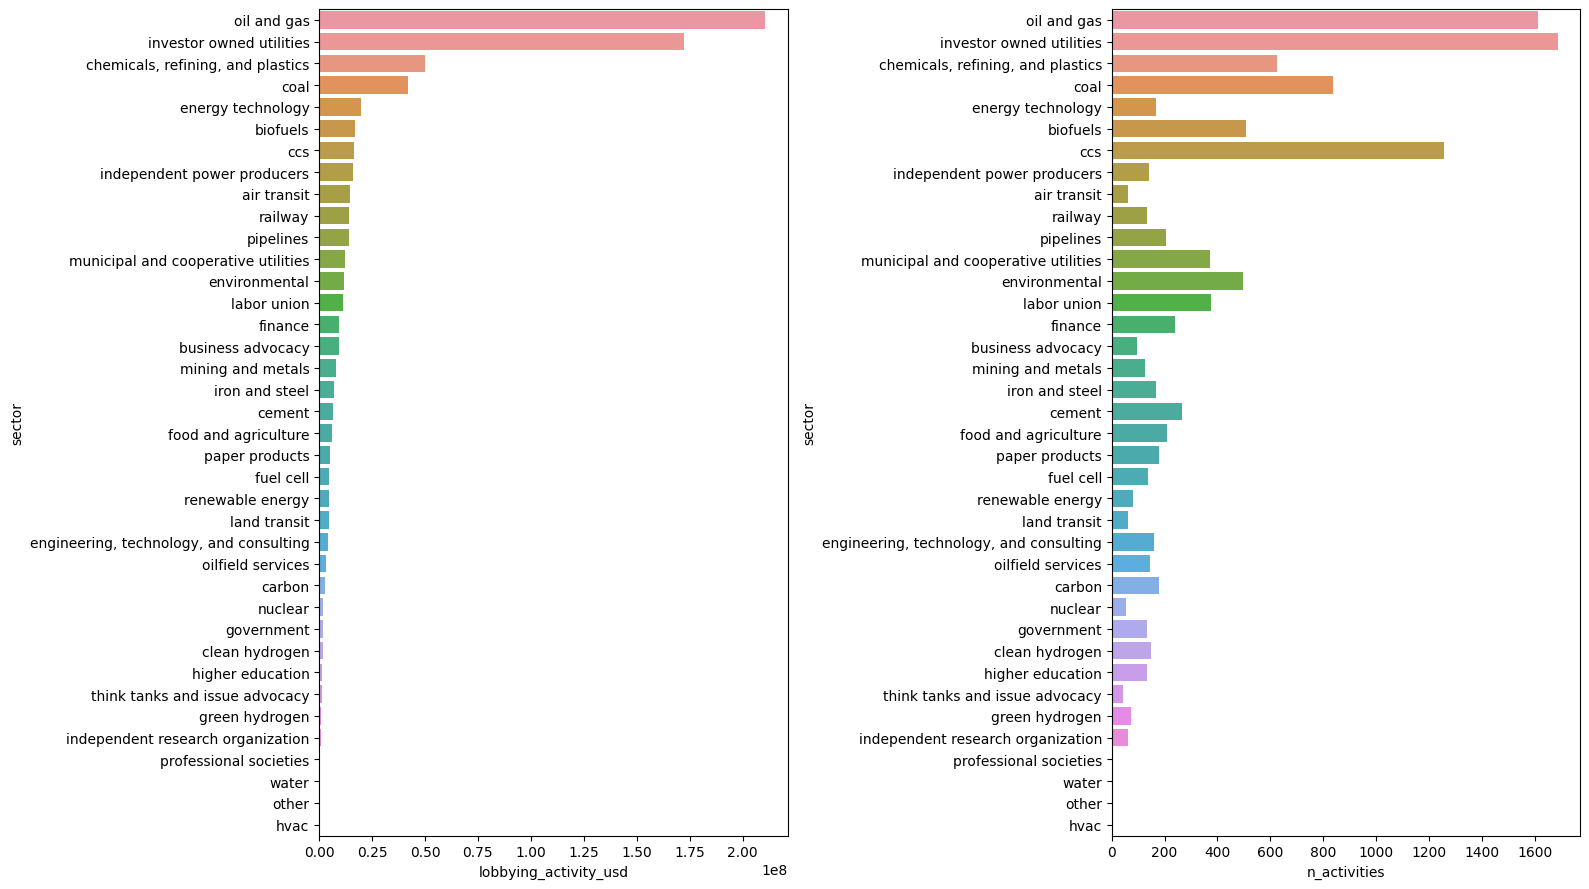

In [131]:
sector_totals_df = (
    cleaned_df[["filing_uuid", "sector", "lobbying_activity_usd"]]
    .loc[cleaned_df.very_likely_ccs == 1]
    .groupby(["sector"])
    .agg({"lobbying_activity_usd": "sum", "filing_uuid": "count"})
    .sort_values(by="lobbying_activity_usd", ascending=False)
).reset_index()
sector_totals_df.columns = ["sector", "lobbying_activity_usd", "n_activities"]
fig, axes = plt.subplots(1, 2, figsize=(16, 9))
sns.barplot(ax=axes[0], data=sector_totals_df, y="sector", x="lobbying_activity_usd")
sns.barplot(ax=axes[1], data=sector_totals_df, y="sector", x="n_activities")
fig.tight_layout()

In [132]:
tot_dollars = lumped_sector_totals_df.lobbying_activity_usd.sum()
tot_activities = sector_totals_df.n_activities.sum()
lumped_sector_totals_df["pct_of_lobbying_dollars"] = [
    100 * x / tot_dollars for x in lumped_sector_totals_df.lobbying_activity_usd
]
sector_totals_df["pct_of_lobbying_dollars"] = [
    100 * x / tot_dollars for x in sector_totals_df.lobbying_activity_usd
]
sector_totals_df["pct_of_lobbying_activities"] = [
    100 * x / tot_activities for x in sector_totals_df.n_activities
]

In [133]:
sector_totals_df

,sector,lobbying_activity_usd,n_activities,pct_of_lobbying_dollars,pct_of_lobbying_activities
0,oil and gas,2.107159e+08,1613,29.775992,14.424969
1,investor owned utilities,1.722996e+08,1687,24.347422,15.086747
2,"chemicals, refining, and plastics",4.993439e+07,626,7.056163,5.598283
3,coal,4.201596e+07,837,5.937219,7.485244
4,energy technology,1.994955e+07,169,2.819045,1.511358
5,biofuels,1.670729e+07,509,2.360885,4.551959
6,ccs,1.658514e+07,1256,2.343624,11.232338
7,independent power producers,1.579789e+07,141,2.232379,1.260955
8,air transit,1.469193e+07,63,2.076097,0.563405
9,railway,1.427882e+07,132,2.017722,1.180469


In [134]:
ff_adjacent = [
    "oil and gas",
    "investor owned utilities",
    "chemicals, refining, and plastics",
    "coal",
    "energy technology",
    "ccs",
    "independent power producers",
    "air transit",
    "railway",
    "pipelines",
    "municipal and cooperative utilities",
    "business advocacy",
    "fuel cell",
    "land transit",
    "oilfield services",
    "carbon",
    "clean hydrogen",
]
sector_totals_df.loc[sector_totals_df.sector.isin(ff_adjacent)].sum()

sector                        oil and gasinvestor owned utilitieschemicals, ...
lobbying_activity_usd                                          609006766.941408
n_activities                                                               7867
pct_of_lobbying_dollars                                               86.057941
pct_of_lobbying_activities                                            70.354141
dtype: object

In [135]:
lumped_sector_totals_df.loc[
    lumped_sector_totals_df.lumped_sector == "NON-FF-INDUSTRY",
    "pct_of_lobbying_dollars",
].sum()

3.7814969908595066

<Axes: xlabel='lobbying_activity_usd', ylabel='lumped_sector'>

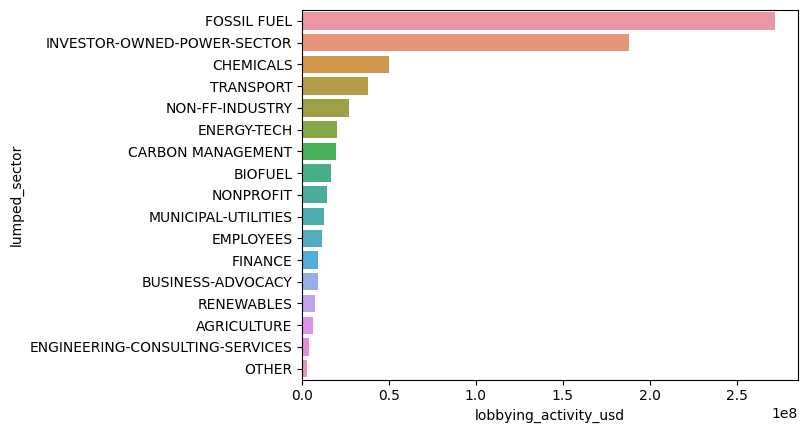

In [136]:
lumped_sector_totals_df = (
    cleaned_df[["lumped_sector", "lobbying_activity_usd"]]
    .loc[cleaned_df.very_likely_ccs == 1]
    .groupby(["lumped_sector"])
    .sum()
    .sort_values(by="lobbying_activity_usd", ascending=False)
).reset_index()
sns.barplot(data=lumped_sector_totals_df, y="lumped_sector", x="lobbying_activity_usd")

In [138]:
cleaned_df.loc[cleaned_df.very_likely_ccs == 1].client_rename.nunique()

541

In [139]:
cleaned_df[
    [
        "client_rename",
        "sector",
        "lobbying_activity_usd",
    ]
].loc[
    (cleaned_df.very_likely_ccs == 1)
].groupby(["client_rename"]).agg(
    {
        "lobbying_activity_usd": sum,
        "sector": "first",
    }
).sort_values(
    by="lobbying_activity_usd", ascending=False
).head(
    16
)  # .index

,lobbying_activity_usd,sector
client_rename,,
OCCIDENTAL PETROLEUM,7.295749e+07,oil and gas
SOUTHERN COMPANY,4.930466e+07,investor owned utilities
EXXON,3.495799e+07,oil and gas
AMERICAN CHEMISTRY COUNCIL,2.531043e+07,"chemicals, refining, and plastics"
EDISON ELECTRIC INSTITUTE,2.482229e+07,investor owned utilities
SHELL,1.873175e+07,oil and gas
BP AMERICA,1.661670e+07,oil and gas
AMERICAN ELECTRIC POWER,1.580816e+07,investor owned utilities
DUKE,1.575382e+07,investor owned utilities


In [176]:
top_fifty = [
    "OCCIDENTAL PETROLEUM",
    "SOUTHERN COMPANY",
    "EXXON",
    "AMERICAN CHEMISTRY COUNCIL",
    "EDISON ELECTRIC INSTITUTE",
    "SHELL",
    "BP AMERICA",
    "AMERICAN ELECTRIC POWER",
    "DUKE",
    "AMERICAS POWER",
    "PEABODY",
    "CALPINE",
    "CHEVRON",
    "AIRLINES FOR AMERICA",
    "GENERAL ELECTRIC",
    "PACIFIC GAS AND ELECTRIC",
]
fifty_df = cleaned_df.loc[
    (cleaned_df.client_rename.isin(top_fifty)) & (cleaned_df.very_likely_ccs == 1)
]
cleaned_df["top_fifty"] = [
    "big sixteen" if x in top_fifty else "rest" for x in cleaned_df.client_rename
]
entities_df = pd.DataFrame(fifty_df[entities].sum(), columns=["n_contacts"])
entities_df.sort_values(by="n_contacts", ascending=False, inplace=True)
# entities_df = entities_df.loc[entities_df.n_contacts > 0]
# for i, row in entities_df.iterrows():
#    if isinstance(row["n_contacts"], str):
#        print(row["n_contacts"])
entities_df.iloc[2:, :].sum()

n_contacts    6892
dtype: int64

In [150]:
for i in entities:
    if "congress" in i:
        print(i)

congressional budget office (cbo)
library of congress (loc)


In [152]:
260 * 20

5200

In [106]:
cleaned_df[["client_rename", "lobbying_activity_usd"]].loc[
    df.very_likely_ccs == 1
].groupby(["client_rename"]).sum().sort_values(
    by="lobbying_activity_usd", ascending=False
).head(
    16
).sum() / 7.090964e08

lobbying_activity_usd    0.502791
dtype: float64

In [153]:
ordered_df = (
    cleaned_df[
        [
            "client_rename",
            "lobbying_activity_usd",
            "sector",
            "lumped_sector",
            "very_lumped_sector",
        ]
    ]
    .loc[df.very_likely_ccs == 1]
    .groupby(["client_rename"])
    .agg(
        {
            "lobbying_activity_usd": "sum",
            "sector": "first",
            "lumped_sector": "first",
            "very_lumped_sector": "first",
        }
    )
    .sort_values(by="lobbying_activity_usd", ascending=False)
)
company = list(ordered_df.index)

data_dict_list = []
for i, c in enumerate(company):
    data_dict = {}
    data_dict["position"] = i + 1
    data_dict["name"] = c
    data_dict["sector"] = ordered_df.loc[c, "sector"]
    data_dict["lumped_sector"] = ordered_df.loc[c, "lumped_sector"]
    data_dict["very_lumped_sector"] = ordered_df.loc[c, "very_lumped_sector"]
    data_dict["organization_ccs_lobbying_dollars"] = ordered_df.loc[
        c, "lobbying_activity_usd"
    ]
    data_dict["cumulative_ccs_lobbying_dollars"] = ordered_df.head(i + 1).sum()[
        "lobbying_activity_usd"
    ]
    data_dict["cumulative_percent_lobbying_dollars"] = (
        data_dict["cumulative_ccs_lobbying_dollars"]
        / ordered_df.lobbying_activity_usd.sum()
    )
    data_dict_list.append(data_dict)

org_total_ccs_lobbying_df = pd.DataFrame(data_dict_list)

In [154]:
bot = 0
for i, row in org_total_ccs_lobbying_df.iterrows():
    top = row["cumulative_ccs_lobbying_dollars"]
    mid = 0.5 * (top - bot) + bot
    org_total_ccs_lobbying_df.loc[i, "cumulative_midpoint"] = mid
    bot = top

In [155]:
for i in cleaned_df.sector.unique():
    print(f'"{i}": rgb_tuple(),')

"green hydrogen": rgb_tuple(),
"investor owned utilities": rgb_tuple(),
"coal": rgb_tuple(),
"railway": rgb_tuple(),
"think tanks and issue advocacy": rgb_tuple(),
"oil and gas": rgb_tuple(),
"renewable energy": rgb_tuple(),
"environmental": rgb_tuple(),
"municipal and cooperative utilities": rgb_tuple(),
"ccs": rgb_tuple(),
"labor union": rgb_tuple(),
"finance": rgb_tuple(),
"government": rgb_tuple(),
"higher education": rgb_tuple(),
"cement": rgb_tuple(),
"mining and metals": rgb_tuple(),
"pipelines": rgb_tuple(),
"paper products": rgb_tuple(),
"independent power producers": rgb_tuple(),
"business advocacy": rgb_tuple(),
"chemicals, refining, and plastics": rgb_tuple(),
"energy technology": rgb_tuple(),
"food and agriculture": rgb_tuple(),
"biofuels": rgb_tuple(),
"hvac": rgb_tuple(),
"nuclear": rgb_tuple(),
"land transit": rgb_tuple(),
"engineering, technology, and consulting": rgb_tuple(),
"independent research organization": rgb_tuple(),
"oilfield services": rgb_tuple(),
"iron and

In [160]:
from utils.data import rgb_tuple

rgb_dict = {
    "independent power producers": rgb_tuple(26, 196, 208),
    "investor owned utilities": rgb_tuple(20, 180, 200),
    "municipal and cooperative utilities": rgb_tuple(30, 50, 220),
    "oil and gas": rgb_tuple(0.15, 0.15, 0.15, denominator=1),
    "power generation and utilities": rgb_tuple(26, 196, 208),
    "chemicals, refining, and plastics": rgb_tuple(0.5, 0.1, 0.5, denominator=1),
    "coal": rgb_tuple(0.21, 0.21, 0.21, denominator=1),
    "air transit": rgb_tuple(0.7, 0.3, 0.01, denominator=1),
    "pipelines": rgb_tuple(0.09, 0.09, 0.09, denominator=1),
    "engineering, technology, and consulting": rgb_tuple(255, 192, 203),
    "mining and metals": rgb_tuple(0.55, 0.05, 0.55, denominator=1),
    "business advocacy": rgb_tuple(0.2, 0.8, 0.6, denominator=1),
    "biofuels": rgb_tuple(0.33, 0.2, 0.15, denominator=1),
    "energy technology": rgb_tuple(240, 180, 210),
    "railway": rgb_tuple(0.9, 0.5, 0.1, denominator=1),
    "labor union": rgb_tuple(0.18, 0.18, 0.95, denominator=1),
    "iron and steel": rgb_tuple(0.9, 0.2, 0.9, denominator=1),
    "renewable energy": rgb_tuple(0.1, 0.8, 0.2, denominator=1),
    "fuel cell": rgb_tuple(0.75, 0.33, 0.03, denominator=1),
    "food and agriculture": rgb_tuple(0.45, 0.22, 0.0, denominator=1),
    "finance": rgb_tuple(186, 184, 108),
    "cement": rgb_tuple(0.7, 0.1, 0.7, denominator=1),
    "environmental": rgb_tuple(0.05, 0.05, 0.7, denominator=1),
    "ccs": rgb_tuple(218, 165, 32),
    "paper products": rgb_tuple(0.6, 0.05, 0.5, denominator=1),
    "oilfield services": rgb_tuple(0.27, 0.27, 0.27, denominator=1),
    "land transit": rgb_tuple(0.9, 0.4, 0.05, denominator=1),
    "nuclear": rgb_tuple(0.07, 0.6, 0.15, denominator=1),
    "think tanks and issue advocacy": rgb_tuple(0.15, 0.15, 0.9, denominator=1),
    "carbon": rgb_tuple(184, 134, 11),
    "higher education": rgb_tuple(0.1, 0.1, 0.8, denominator=1),
    "clean hydrogen": rgb_tuple(0.35, 0.35, 0.35, denominator=1),
    "green hydrogen": rgb_tuple(0.12, 0.9, 0.25, denominator=1),
    "independent research organization": rgb_tuple(0.13, 0.13, 0.78, denominator=1),
    "government": rgb_tuple(1, 0.2, 0.2, denominator=1),
    "water": rgb_tuple(1, 0.5, 0.5, denominator=1),
    "professional societies": rgb_tuple(0.25, 0.9, 0.65, denominator=1),
    "other": rgb_tuple(250, 250, 250),
    "hvac": rgb_tuple(250, 250, 250),
}
rgb_lumped_dict = {
    "INVESTOR-OWNED-POWER-SECTOR": rgb_tuple(171, 175, 174),
    "MUNICIPAL-UTILITIES": rgb_tuple(165, 205, 165),
    "FINANCE": rgb_tuple(120, 200, 235),
    "ENERGY-TECH": rgb_tuple(160, 75, 34),
    "FOSSIL FUEL": rgb_tuple(60, 65, 66),
    "UTILITY": rgb_tuple(171, 175, 174),
    "CHEMICALS": rgb_tuple(175, 183, 11),
    "TRANSPORT": rgb_tuple(198, 45, 66),
    "ENGINEERING-CONSULTING-SERVICES": rgb_tuple(139, 66, 26),
    "NON-FF-INDUSTRY": rgb_tuple(77, 1, 11),
    "BUSINESS-ADVOCACY": rgb_tuple(116, 189, 229),
    "BIOFUEL": rgb_tuple(184, 134, 11),
    "EMPLOYEES": rgb_tuple(0, 115, 255),
    "RENEWABLES": rgb_tuple(42, 126, 25),
    "AGRICULTURE": rgb_tuple(255, 140, 0),
    "AG-AND-BIOFUEL": rgb_tuple(255, 140, 0),
    "OTHER": rgb_tuple(139, 66, 26),
    "NONPROFIT": rgb_tuple(21, 27, 141),
    "CARBON MANAGEMENT": rgb_tuple(213, 129, 230),
}

In [164]:
import squarify
from utils.data import rgb_tuple

color_assignments = dict(
    zip(
        list(org_total_ccs_lobbying_df.very_lumped_sector.unique()),
        [
            rgb_tuple(60, 65, 66),
            "dimgrey",
            "lightblue",
            "tab:purple",
            "tab:orange",
            "tab:red",
            "tab:green",
            rgb_tuple(255, 140, 0),
            rgb_tuple(0, 140, 0),
            rgb_tuple(255, 140, 200),
        ],
    )
)

org_total_ccs_lobbying_df["detail_color"] = [
    rgb_lumped_dict[x] for x in org_total_ccs_lobbying_df.lumped_sector
]
org_total_ccs_lobbying_df["very_detail_color"] = [
    rgb_dict[x] for x in org_total_ccs_lobbying_df.sector
]
org_total_ccs_lobbying_df["color"] = [
    color_assignments[x] for x in org_total_ccs_lobbying_df.very_lumped_sector
]

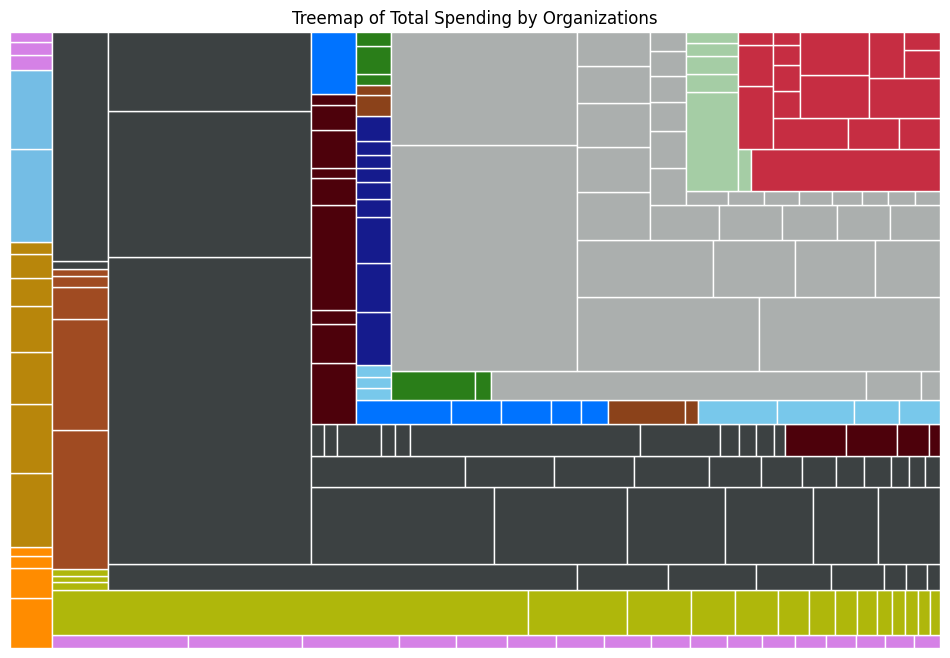

In [166]:
norg = 200
plot_df = (
    org_total_ccs_lobbying_df.loc[org_total_ccs_lobbying_df.position < norg]
    .sort_values(
        by=["very_lumped_sector", "lumped_sector", "sector"]
    )  # , "organization_ccs_lobbying_dollars"])
    .copy()
)

# Create treemap

plt.figure(figsize=(12, 8))
squarify.plot(
    sizes=list(plot_df.organization_ccs_lobbying_dollars),
    # label=list(
    #    org_total_ccs_lobbying_df.loc[org_total_ccs_lobbying_df.position < norg].name
    # ),
    color=list(plot_df.detail_color),  # squarify.normalize_sizes(sizes, 100, 100),
    alpha=1,
    ec="white",
)

# Add title and display
plt.title("Treemap of Total Spending by Organizations")
plt.axis("off")  # Turn off the axes
plt.show()

In [ ]:
import plotly.express as px


px.treemap(
    plot_df,
    path=["very_lumped_sector", "sector", "name", "organization_ccs_lobbying_dollars"],
    branchvalues="total",
)

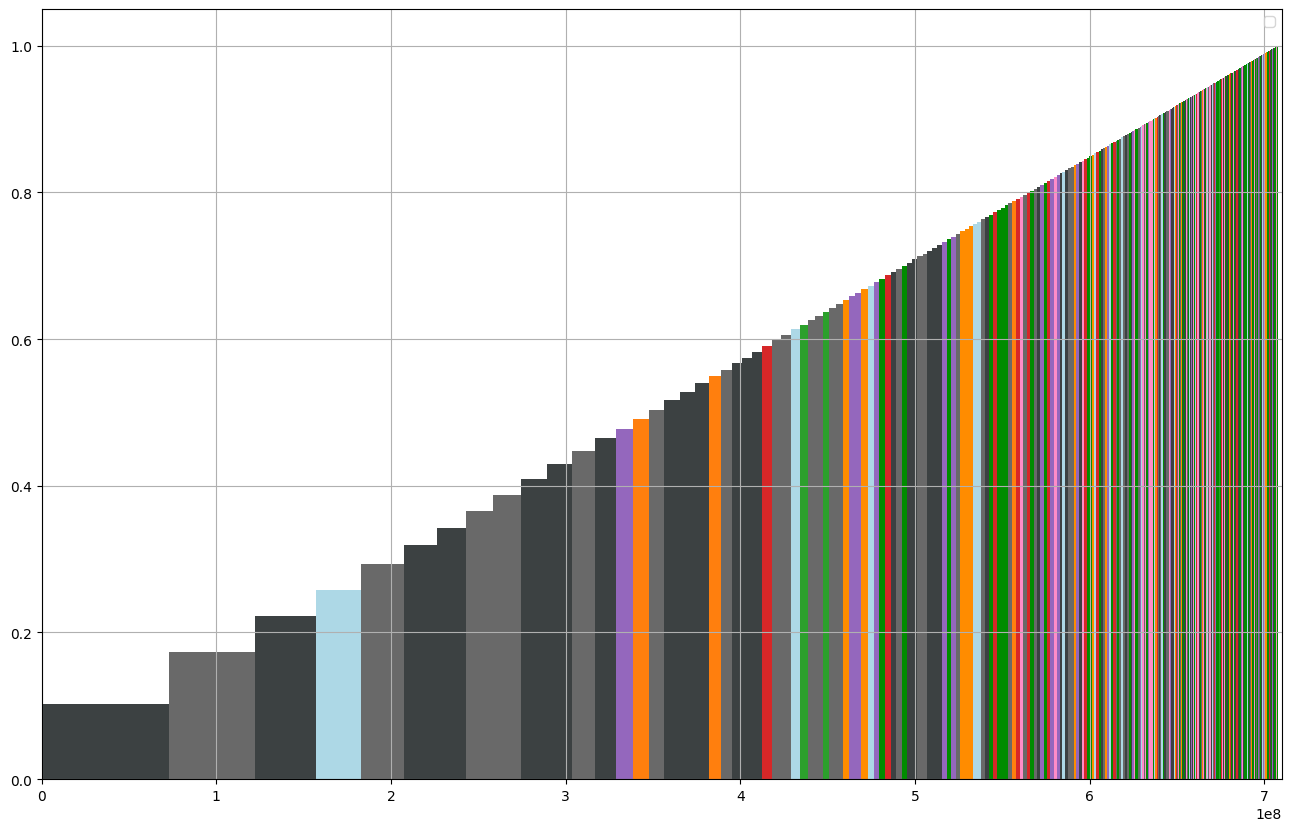

In [167]:
fig, ax = plt.subplots(1, 1, figsize=(16, 10))
plt.subplot(1, 1, 1)
norgs = 555
plt.bar(
    x=org_total_ccs_lobbying_df.loc[
        org_total_ccs_lobbying_df.position < norgs
    ].cumulative_midpoint,
    height=org_total_ccs_lobbying_df.loc[
        org_total_ccs_lobbying_df.position < norgs
    ].cumulative_percent_lobbying_dollars,
    width=org_total_ccs_lobbying_df.loc[
        org_total_ccs_lobbying_df.position < norgs
    ].organization_ccs_lobbying_dollars,
    color=list(
        org_total_ccs_lobbying_df.loc[org_total_ccs_lobbying_df.position < norgs].color
    ),
)
plt.xlim([0, 7.10e8])
plt.legend()
plt.grid()
plt.show()
# palette=)

In [168]:
cleaned_df[["client_rename", "lobbying_activity_usd"]].loc[
    cleaned_df.very_likely_ccs == 1
].groupby(["client_rename"]).sum().sort_values(
    by="lobbying_activity_usd", ascending=False
).sum()

lobbying_activity_usd    7.076706e+08
dtype: float64

### Figure showing lobbying dollars through time

In [171]:
df[["filing_year", "lobbying_activity_usd"]].loc[(df.very_likely_ccs == 1)].sum()

filing_year              2.273308e+07
lobbying_activity_usd    7.103789e+08
dtype: float64

Text(0.5, 1.0, 'Dollars spent lobbying the US federal government regarding CCS')

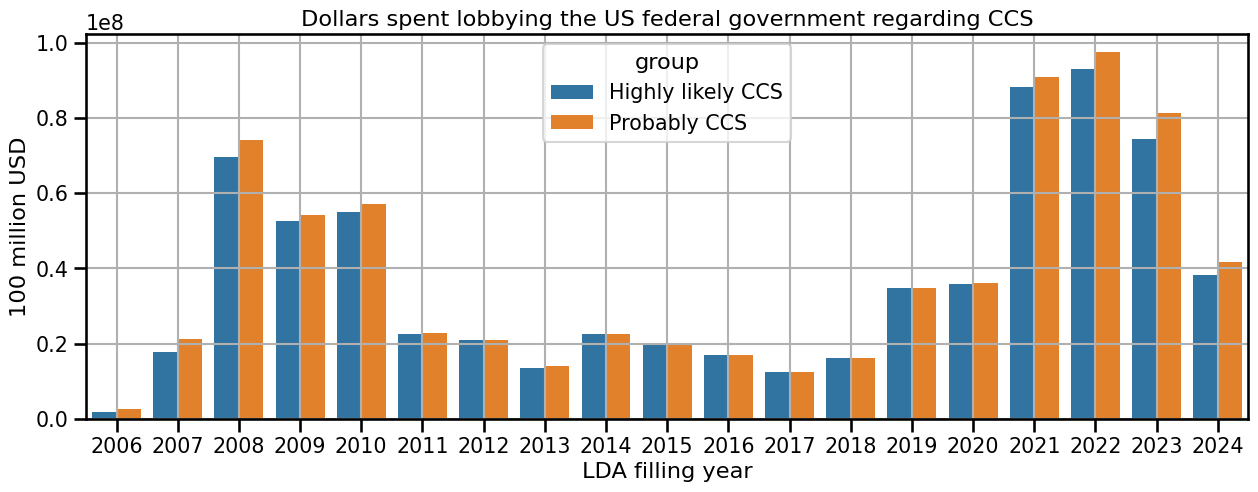

In [173]:
# combined data to plot
sns.set_context("talk", font_scale=0.9)
tmp_likely_df = (
    cleaned_df[["filing_year", "lobbying_activity_usd"]]
    .loc[(cleaned_df.likely_ccs == 1)]
    .groupby(["filing_year"])
    .sum()
    .sort_values(by="lobbying_activity_usd", ascending=False)
    .reset_index()
).copy(deep=True)
tmp_likely_df["group"] = "Probably CCS"
tmp_def_df = (
    cleaned_df[["filing_year", "lobbying_activity_usd"]]
    .loc[(cleaned_df.very_likely_ccs == 1)]
    .groupby(["filing_year"])
    .sum()
    .sort_values(by="lobbying_activity_usd", ascending=False)
    .reset_index()
).copy(deep=True)
tmp_def_df["group"] = "Highly likely CCS"
plot_df = pd.concat([tmp_def_df, tmp_likely_df])

# plot figure
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

sns.barplot(
    data=plot_df, ax=ax, x="filing_year", y="lobbying_activity_usd", hue="group"
)
ax.set_xlim([4.5, 23.5])
ax.grid()
ax.set_ylabel("100 million USD")
ax.set_xlabel("LDA filling year")
ax.set_title(
    "Dollars spent lobbying the US federal government regarding CCS",
)

Text(0.5, 1.0, 'Dollars spent lobbying the US federal government regarding CCS')

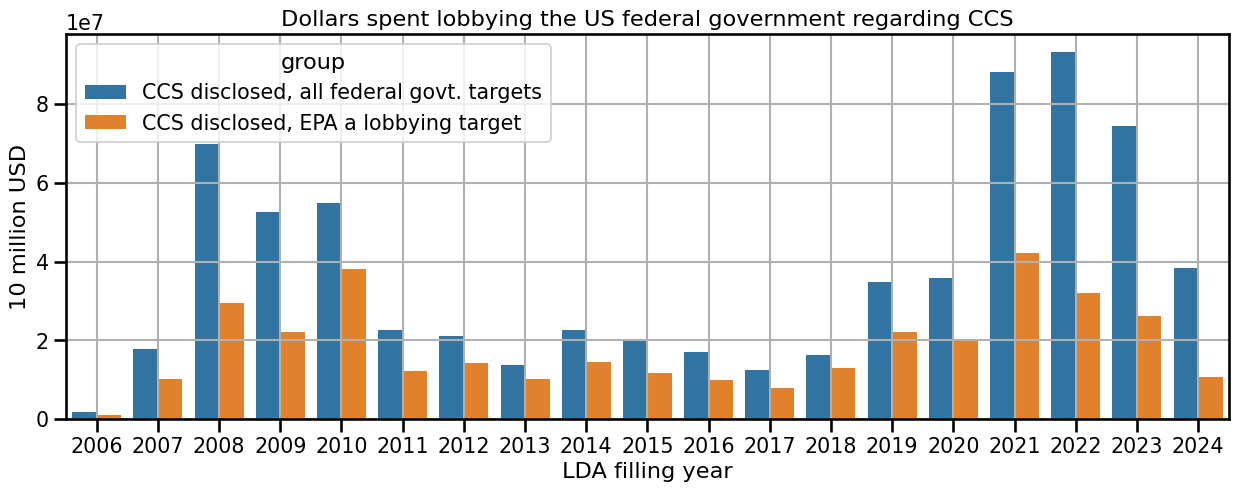

In [175]:
# combined data to plot
sns.set_context("talk", font_scale=0.9)
tmp_likely_df = (
    cleaned_df[["filing_year", "lobbying_activity_usd"]]
    .loc[
        (cleaned_df.very_likely_ccs == 1)
        & (cleaned_df["environmental protection agency (epa)"] == 1)
    ]
    .groupby(["filing_year"])
    .sum()
    .sort_values(by="lobbying_activity_usd", ascending=False)
    .reset_index()
).copy(deep=True)
tmp_likely_df["group"] = "CCS disclosed, EPA a lobbying target"
tmp_def_df = (
    cleaned_df[["filing_year", "lobbying_activity_usd"]]
    .loc[(cleaned_df.very_likely_ccs == 1)]
    .groupby(["filing_year"])
    .sum()
    .sort_values(by="lobbying_activity_usd", ascending=False)
    .reset_index()
).copy(deep=True)
tmp_def_df["group"] = "CCS disclosed, all federal govt. targets"
plot_df = pd.concat([tmp_def_df, tmp_likely_df])

# plot figure
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

sns.barplot(
    data=plot_df, ax=ax, x="filing_year", y="lobbying_activity_usd", hue="group"
)
ax.set_xlim([4.5, 23.5])
ax.grid()
ax.set_ylabel("10 million USD")
ax.set_xlabel("LDA filling year")
ax.set_title(
    "Dollars spent lobbying the US federal government regarding CCS",
)

Text(0.5, 1.0, 'Dollars spent lobbying the US federal government regarding CCS')

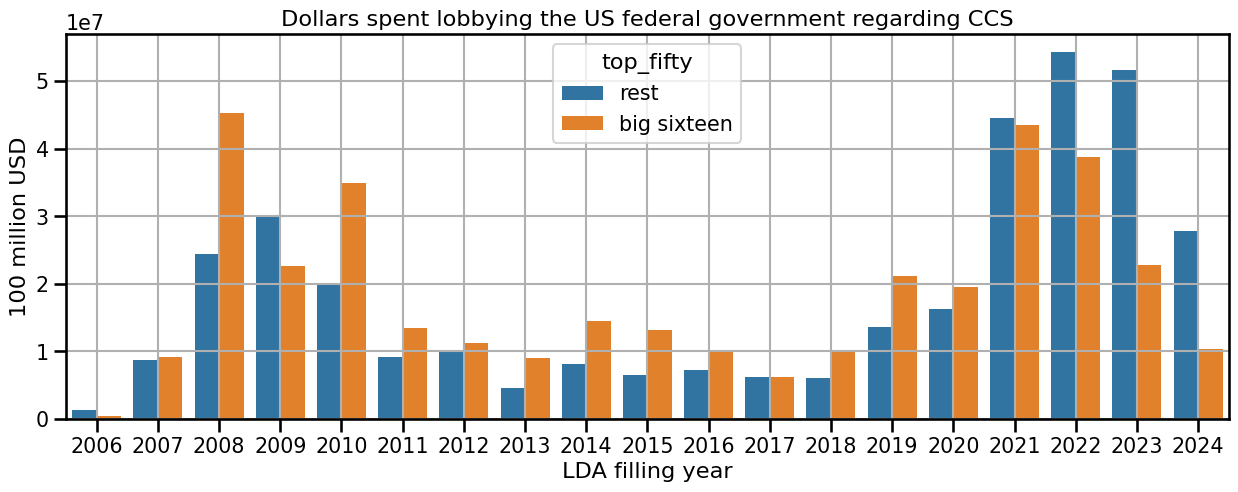

In [185]:
plot_df = (
    cleaned_df[["filing_year", "top_fifty", "lobbying_activity_usd"]]
    .loc[(cleaned_df.very_likely_ccs == 1)]
    .groupby(["filing_year", "top_fifty"])
    .sum()
    .sort_values(by="lobbying_activity_usd", ascending=False)
    .reset_index()
)
# plot figure
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

sns.barplot(
    data=plot_df, ax=ax, x="filing_year", y="lobbying_activity_usd", hue="top_fifty"
)
ax.set_xlim([4.5, 23.5])
ax.grid()
ax.set_ylabel("100 million USD")
ax.set_xlabel("LDA filling year")
ax.set_title(
    "Dollars spent lobbying the US federal government regarding CCS",
)

In [204]:
25000 / 2000

12.5

In [210]:
year_df = (
    cleaned_df[["filing_year", "lobbying_activity_usd"]]
    .loc[(cleaned_df.very_likely_ccs == 1)]
    .groupby(["filing_year"])
    .sum()
    .sort_values(by="lobbying_activity_usd", ascending=False)
    .reset_index()
)
year_df.loc[year_df.filing_year > 2018].sum()

filing_year              1.212900e+04
lobbying_activity_usd    3.644124e+08
dtype: float64

In [201]:
plot_df.loc[plot_df.filing_year > 2000].sum()

filing_year                                                           96600
branch                    executiveexecutiveexecutiveexecutiveexecutivee...
lobbying_contact_count                                              49667.0
dtype: object

Text(0.5, 1.0, 'Lobbying contacts regarding CCS')

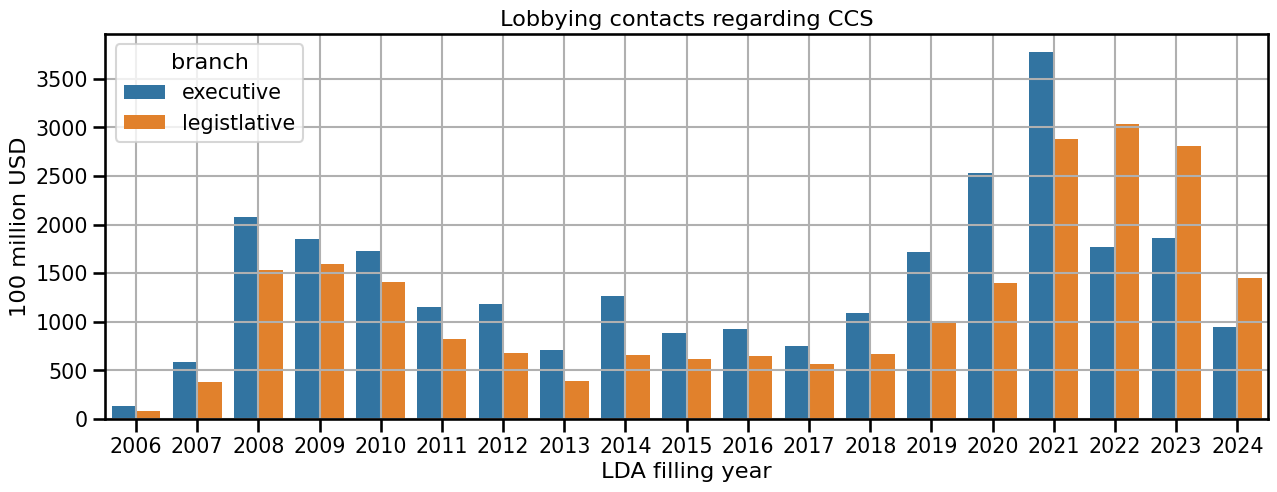

In [198]:
 =plot_df (
    cleaned_df[
        ["filing_year", "executive_entities_lobbied", "legistlative_entities_lobbied"]
    ]
    .loc[(cleaned_df.very_likely_ccs == 1)]
    .groupby(["filing_year"])
    .sum()
    .sort_values(by="executive_entities_lobbied", ascending=False)
    .reset_index()
).melt(id_vars="filing_year")
plot_df.columns = ["filing_year", "branch", "lobbying_contact_count"]
plot_df["branch"] = [x.replace("_entities_lobbied", "") for x in plot_df.branch]
# plot figure
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

sns.barplot(
    data=plot_df, ax=ax, x="filing_year", y="lobbying_contact_count", hue="branch"
)
ax.set_xlim([4.5, 23.5])
ax.grid()
ax.set_ylabel("100 million USD")
ax.set_xlabel("LDA filling year")
ax.set_title(
    "Lobbying contacts regarding CCS",
)

Text(0, 0.5, '10 million USD')

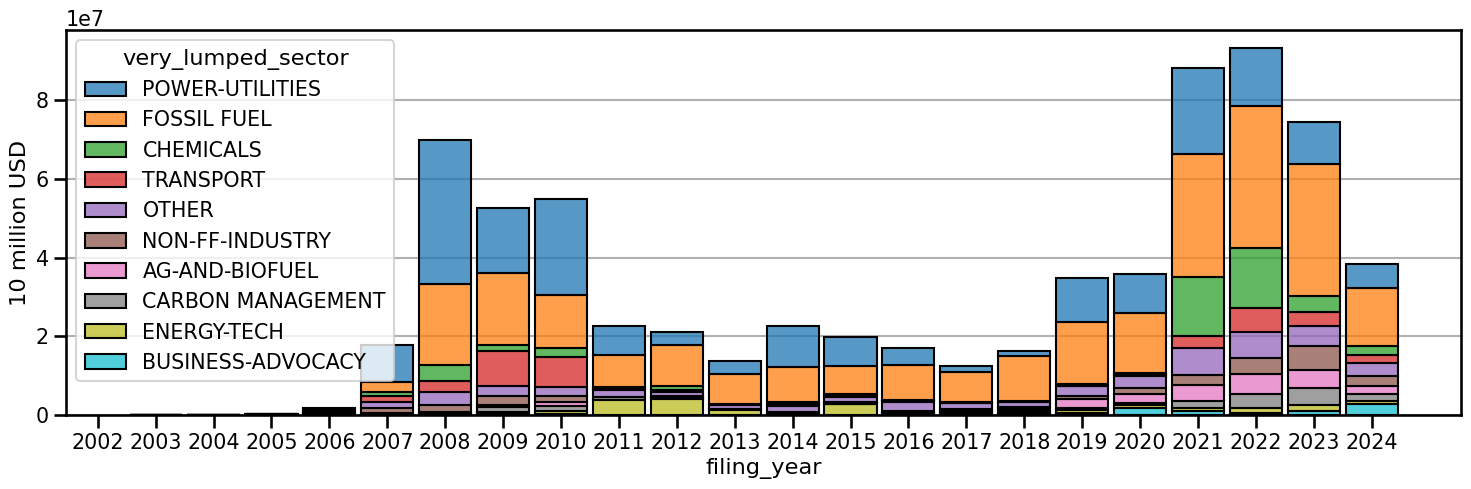

In [182]:
# lobbying_activity_usd
years = list(range(2002, 2025))
cleaned_df["very_lumped_sector"] = [
    lumped_sector_dict["very_lumped"][x] for x in cleaned_df.sector
]
tmp_df = (
    cleaned_df[["filing_year", "lobbying_activity_usd", "very_lumped_sector"]]
    .loc[(cleaned_df.very_likely_ccs == 1)]  # & (cleaned_df.epa == 1)]
    .groupby(["very_lumped_sector", "filing_year"])
    .sum()
    .sort_values(by="lobbying_activity_usd", ascending=False)
    .reset_index()
).copy(deep=True)
fig, ax = plt.subplots(1, 1, figsize=(18, 5))
ax = sns.histplot(
    data=tmp_df,
    x="filing_year",
    bins=[0.5 + x for x in years],
    hue="very_lumped_sector",
    shrink=0.9,
    weights="lobbying_activity_usd",
    multiple="stack",
)
ax.set_xticks(years)
ax.set_xticklabels([str(x) for x in years])
ax.set_axisbelow(True)
ax.yaxis.grid()
ax.set_ylabel("10 million USD")
# ax.legend(ncols=3, loc="upper center")

In [183]:
cleaned_df[["filing_year", "lobbyist_apportioned_usd", "very_lumped_sector"]].loc[
    (cleaned_df.very_likely_ccs == 1)
    & (cleaned_df.filing_year.isin([2019, 2020, 2021, 2022]))
].sum()

KeyError: "['lobbyist_apportioned_usd'] not in index"

In [ ]:
cleaned_df.to_csv("draft_1_ccs_lda.csv")

In [ ]:
companies = list(
    df[["lobbyist_apportioned_usd", "client_rename"]]
    .loc[
        # (df.sector == "food and agriculture")
        (df["likely_ccs"] == 1)
        & (df.very_likely_ccs == 0)
        # (df.sector == "renewable energy")
        # (df.sector == "other")
        # & (df.very_likely_ccs == 1)
    ]
    .groupby("client_rename")
    .sum()
    .sort_values(by="lobbyist_apportioned_usd", ascending=False)
    .head(60)
    .index
)

In [ ]:
for co in companies:
    print(f"************** {co} ************ ")
    for i, row in df.loc[
        (df.client_rename == co) & (df.likely_ccs == 1) & (df.very_likely_ccs == 0)
    ].iterrows():
        if terms_present(row["clean_description"], maybe_ccs):
            print(f"maybe: {i}")
            print(row["description"])

            for i in maybe_ccs:
                if terms_present(row["clean_description"], [i]):
                    print(i)
        if terms_present(row["clean_description"], probably_ccs):
            print(f"probably: {i}")
            print(row["description"])

            for i in probably_ccs:
                if terms_present(row["clean_description"], [i]):
                    print(i)
        if terms_present(row["clean_description"], single_terms):
            print(f"single: {i}")
            print(row["description"])
            for i in single_terms:
                if terms_present(row["clean_description"], [i]):
                    print(i)
        if any(
            [
                terms_present(row["clean_description"], y, find_any=False)
                for y in multiple_terms
            ]
        ):
            print(f"multiple: {i}")
            print(row["clean_description"])
            for i in multiple_terms:
                if terms_present(row["clean_description"], i):
                    print(i)
        if row["ccs_bills"] == 1:
            print("---ccs bills!")
            print(row["clean_description"])
            for b in ccs_bills:
                if terms_present(row["clean_description"], [b]):
                    print(b)

In [ ]:
sector_list = list(sector_mapping.keys())
for s1 in sector_list:
    for s2 in sector_list:
        if s1 != s2:
            if len(set(sector_mapping[s1]).intersection(set(sector_mapping[s2]))) > 0:
                print(f"Intersection of {s1} and {s2}:")
                print(
                    list(set(sector_mapping[s1]).intersection(set(sector_mapping[s2])))
                )

In [ ]:
for co in ["DARLING INGREDIENTS", "DARLING INTERNATIONAL"]:
    for i in list(
        ccs_df.loc[
            ccs_df.client_rename
            == co
            # ].clean_client_general_description.unique()
        ].client_name.unique()
    ):
        if "ELEPHANT" in i:
            print(f"'{i}':'DOW',")
        else:
            print(f"{i}: {substitute(i,use_basename=True)}")

In [ ]:
df.loc[
    (df.ccs_description == 1)
    | (df.ccs_company == 1)
    | (df.very_likely_ccs == 1)
    | (df["probably ccs"] == 1)
    | ((df.oilandgas == 1) & (df["maybe ccs"] == 1))
    | ((df.utility == 1) & (df["maybe ccs"] == 1))
    | ((df.air_transport == 1) & (df["maybe ccs"] == 1))
    | ((df.land_transport == 1) & (df["maybe ccs"] == 1))
    | ((df.water_transport == 1) & (df["maybe ccs"] == 1))
    | ((df.biofuels == 1) & (df["maybe ccs"] == 1))
    | ((df.steel_company == 1) & (df["maybe ccs"] == 1))
][["lobbyist_apportioned_usd", "activity_apportioned_usd"]].sum()

In [ ]:
for i, row in df.loc[
    (df["maybe ccs"] == 1)
    & ((df.oilandgas == 1) | (df.utility == 1))
    & (df.ccs_description == 0)
].iterrows():
    print(f"{row['client_rename']}: {row['clean_description']}")

In [ ]:
for i, row in df.loc[
    (df["probably ccs"] == 1) & (df.oilandgas == 0) & (df.ccs_description == 0)
].iterrows():
    print(f"{row['client_rename']}: {row['clean_description']}")

In [ ]:
df.loc[df["potentially ccs"] == 1][
    ["lobbyist_apportioned_usd", "activity_apportioned_usd"]
].sum()

In [ ]:
sector_assignments = yaml_to_dict("sectors.yml")


all_companies = []
for _, value in sector_assignments.items():
    all_companies = all_companies + value
print(all_companies)

company_sector_dict = {}
for k, vv in sector_assignments.items():
    for v in vv:
        company_sector_dict = company_sector_dict | {v: k}

In [ ]:
company_sector_dict = invert_sector_dict(
    "/Users/lindseygulden/dev/leg-up-private/projects/lobbying/sectors.yml"
)
lumped_sector_dict = yaml_to_dict(
    "/Users/lindseygulden/dev/leg-up-private/projects/lobbying/lumped_sectors.yml"
)["lumped_sector_assignments"]
df["sector"] = df["client_rename"].copy()
df["sector"] = [company_sector_dict[c] for c in df.sector]
df["lumped_sector"] = [lumped_sector_dict[c] for c in df.sector]

In [ ]:
likely_ccs_by_year_sector_df = (
    df.loc[(df.lumped_sector != "REMOVE") & (df["likely_ccs"] == 1)][
        ["filing_year", "very_lumped_sector", "lobbyist_apportioned_usd"]
    ]
    .groupby(["filing_year", "very_lumped_sector"])
    .sum()
    .sort_values(by=["filing_year", "lobbyist_apportioned_usd"], ascending=False)
    .reset_index()
)
definitely_ccs_by_year_sector_df = (
    df.loc[(df.lumped_sector != "REMOVE") & (df["very_likely_ccs"] == 1)][
        ["filing_year", "very_lumped_sector", "lobbyist_apportioned_usd"]
    ]
    .groupby(["filing_year", "very_lumped_sector"])
    .sum()
    .sort_values(by=["filing_year", "lobbyist_apportioned_usd"], ascending=False)
    .reset_index()
)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mc
import seaborn as sns

In [ ]:
import json

df["epa"] = [1 if "epa" in json.dumps(x).lower() else 0 for x in df.entities]

In [ ]:
hue_order = [
    x for x in sorted(list(set(df.very_lumped_sector.unique()))) if x != "REMOVE"
]

colors = [
    "chartreuse",
    "skyblue",
    "brown",
    "magenta",
    "goldenrod",
    "black",
    "crimson",
    "pink",
    "rebeccapurple",
    "forestgreen",
    "blue",
    "grey",
    "tab:purple",
]
color_palette = sns.color_palette(colors)
palette = color_palette
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
sns.barplot(
    ax=ax,
    data=definitely_ccs_by_year_sector_df,
    # data=likely_ccs_by_year_sector_df,
    x="filing_year",
    y="lobbyist_apportioned_usd",
    hue="very_lumped_sector",
    palette=color_palette,
    hue_order=hue_order,
)
ax.grid()
ax.legend(ncol=3, loc="upper center")
ax.set_xlim([5.5, 23.5])
ax.set_ylabel("Federal lobbying dollars spent")
ax.set_xlabel("LDA Filing year")
plt.show()

In [ ]:
for x in df.client_rename.loc[~df.client_rename.isin(all_companies)].unique():
    print(x.replace(",", ""))

In [ ]:
for i, row in df.clean_description.value_counts().items():
    print(i)

In [ ]:
df.client_general_description.fillna("", inplace=True)
df.loc[
    [
        ("ohio" in x.lower())  # | ("e&p" in x.lower())
        # for x in df.client_general_description
        for x in df.client_rename
    ]
].client_rename.unique()

In [ ]:
for i, row in df.client_rename.value_counts().items():
    print(f"{i}")

In [ ]:
df[["lobbyist_apportioned_usd", "client_rename"]].loc[df.ccs == 1].groupby(
    "client_rename"
).sum().sort_values(by="lobbyist_apportioned_usd", ascending=False).head(60)

In [ ]:
xom_entities = [x for x in df.columns if x in entities]
tmp = df[xom_entities].sum()
subset_entities = list(tmp[tmp > 0].index)
greenwashing_df = df.loc[df.ccs == 1].copy()
greenwashing_df[subset_entities].sum()

In [ ]:
search_string = '"carbon capture"OR"capture of carbon"OR"capture of co2"OR"CCUS"OR"CCS"OR"storage of carbon dioxide"OR"storage of co2"OR"capture and sequestration of carbon dioxide"OR"capture and sequestration of co2"OR"blue hydrogen"OR"hydrogen hub"OR"clean hydrogen"OR"45Q"OR"45V"OR"inflation reduction act"OR"117-169"OR"117-58"'

In [ ]:
query_filings = f"https://lda.senate.gov/api/v1/filings/?filing_specific_lobbying_issues={search_string}&filing_period=year_end"

f = requests.get(query_filings)

### Info about congress.gov search for bills with ccs relevance

In [ ]:
#query for congress.gov search
https://www.congress.gov/u/ISk7JcnkfFMeJIdw4sMwB

# "carbon capture" OR "capture of carbon" OR "CCUS" OR "CCS" OR "storage of carbon dioxide" OR "storage of co2" OR "sequestration of carbon dioxide" OR "sequestration of co2" OR "blue hydrogen" OR "clean hydrogen" OR "45Q" OR "45V"

In [ ]:
xom_word_cloud = [
    x.replace("Discussions related to", "")
    .replace("provisions", "")
    .replace("Provisions", "")
    for x in df.description.to_list()
]
xom_word_cloud = [
    x.replace("related", "")
    .replace("Related", "")
    .replace("issues", "")
    .replace("provisions related", "")
    for x in xom_word_cloud
]

In [ ]:
from wordcloud import WordCloud

word_cloud = WordCloud(background_color="white")
word_cloud.generate(" ".join(xom_word_cloud))
import os
from PIL import Image
import numpy as np
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt

plt.imshow(word_cloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
query_congress = f"https://api.congress.gov/v3/bill/118/hr/1262/summaries?format=json&api_key={data_gov_api_key}"
s = requests.get(query_congress)
s.json()["summaries"][-1]["text"]

In [ ]:
def parse_dollars_spent(income, expense):
    if (income is None) & (expense is None):
        return "income and expense are none", 0.0
    if income is None:
        return "corporation lobbying for itself", float(expense)
    if expense is None:
        return "hired lobbying firm", float(income)
    else:
        return "both income and expense > $0", float(income) + float(expense)


def initialize_row(entity_df, result, filing_id):
    # set up row dictionary using entity booleans
    initialize_row_dict = dict(
        zip(
            [x.lower() for x in list(entity_df["name"])],
            [0] * len(list(entity_df["name"])),
        )
    )
    (
        initialize_row_dict["who_is_lobbying"],
        initialize_row_dict["dollars_spent_lobbying"],
    ) = parse_dollars_spent(result["income"], result["expenses"])
    initialize_row_dict["filing_id"] = filing_id
    initialize_row_dict["url"] = result["url"]
    initialize_row_dict["filing_year"] = int(result["filing_year"])
    initialize_row_dict["filing_period"] = result["filing_period"]
    initialize_row_dict["lobbyist_posted_by_name"] = result["posted_by_name"]

    initialize_row_dict["lobbyist_registrant_id"] = result["registrant"]["id"]
    initialize_row_dict["lobbyist_registrant_name"] = result["registrant"]["name"]
    initialize_row_dict["lobbyist_registrant_contact"] = result["registrant"][
        "contact_name"
    ]
    initialize_row_dict["client_id"] = result["client"]["id"]
    initialize_row_dict["client_client_id"] = result["client"]["client_id"]
    initialize_row_dict["client_name"] = result["client"]["name"]
    initialize_row_dict["affiliated_organizations_present"] = False
    if len(result["affiliated_organizations"]) > 0:
        initialize_row_dict["affiliated_organizations_present"] = True
    initialize_row_dict["convictions_present"] = False
    if len(result["conviction_disclosures"]) > 0:
        initialize_row_dict["convictions_present"] = True
    return initialize_row_dict

In [ ]:
def parse_lobbyists(df, lobbyists, details):
    lobby_dict = {}
    lobby_dict["firm_name"] = details["lobbyist_registrant_name"]
    lobby_dict["client_name"] = details["client_name"]
    lobby_dict["general_issue_code"] = details["general_issue_code"]
    lobby_dict["description"] = details["description"]
    lobby_dict["filing_period"] = details["filing_period"]
    lobby_dict["filing_year"] = details["filing_year"]
    lobby_dict["url"] = details["url"]
    lobby_dict["filing_id"] = details["filing_id"]

    lobby_list = []
    # unpack lobbyists list
    for lobbyist in lobbyists:
        lobby_dict["name"] = (
            lobbyist["lobbyist"]["last_name"]
            + ", "
            + lobbyist["lobbyist"]["first_name"]
        )
        lobby_dict["covered_position"] = "None"
        if "covered_position" in lobbyist:
            lobby_dict["covered_position"] = lobbyist["covered_position"]
        lobby_dict["id"] = lobbyist["lobbyist"]["id"]
        lobby_list.append(lobby_dict.copy())

    if df is None:
        df = pd.DataFrame(
            columns=[
                "name",
                "firm_name",
                "client_name",
                "general_issue_code",
                "description",
                "covered_position",
                "filing_year",
                "filing_period",
                "url",
            ]
        )

    df = pd.concat([df, pd.DataFrame(lobby_list)])
    return df

In [ ]:
# get govt entity names
entity_df = pd.DataFrame(government_entities)

corporations = [
    "Exxon",
    "ExxonMobil",
]  # 'exxon' alone includes ExxonMobil Exxon Mobil Corp, Exxon Mobil Corporation, etc. ['Exxon Mobil'.upper(),'ExxonMobil'.upper(),'Exxon'

row_list = (
    []
)  # initialize holder for each row (which corresponds to a single lobbying activity)
max_page = 20

filing_id = 0
lobbyists_df = None
for corporation in corporations:
    for year in list(range(1999, 2025)):
        page = 1
        while page < max_page:
            # print(f"Querying page {page} for year {year}")
            query_filings = f'https://lda.senate.gov/api/v1/filings/?client_name="{corporation}"&filing_period=year_end&filing_year={year}&page={page}'

            f = requests.get(query_filings)

            if "detail" in f.json():
                break

            results = f.json()["results"]
            page += 1  # increase the page for the next query
            # print(f"{len(results)} filings found")
            if len(results) < 25:
                page = max_page

            for result in results:
                row_dict_base = initialize_row(entity_df, result, filing_id)
                activities = result["lobbying_activities"]

                for activity_count, activity in enumerate(activities):
                    row_dict = row_dict_base.copy()
                    # set up row dictionary using entity booleans
                    row_dict["activity_count"] = activity_count
                    row_dict["general_issue_code"] = activity["general_issue_code"]
                    row_dict["description"] = activity["description"]
                    lobbyists_df = parse_lobbyists(
                        lobbyists_df, activity["lobbyists"], row_dict
                    )

                    lobbyist_id_list = []
                    for lobbyist in activity["lobbyists"]:
                        lobbyist_id_list.append(lobbyist["lobbyist"]["id"])

                    row_dict["lobbyist_ids"] = "; ".join(
                        ["None" if x is None else str(x) for x in lobbyist_id_list]
                    )
                    for entity in activity["government_entities"]:
                        row_dict[entity["name"].lower()] = 1

                    row_list.append(row_dict.copy())

                    row_dict.clear()
                filing_id += 1

tmp = pd.DataFrame(row_list)
entities_influenced = tmp[[x.lower() for x in list(entity_df["name"])]].sum()
zeroed = list(entities_influenced[entities_influenced == 0].index)
xom_df = tmp[[x for x in tmp.columns.values if x not in zeroed]]
xom_df = xom_df.drop_duplicates(subset=xom_df.columns.difference(["filing_id"]))
xom_unique_filing_ids = list(
    xom_df.filing_id.unique()
)  # keep a list of the non-duplicate filing ids

# keep only right company aliases
company_aliases = [
    "EXXON MOBIL CORP",
    "EXXONMOBIL CHEMICAL CO",
    "EXXON USA",
    "EXXON CO USA",
    "EXXON MOBIL CORPORATION",
    "EXXON MOBIL PRODUCTION CO",
    "EXXON MOBIL",
    "EXXONMOBIL CORPORATION",
    "EXXONMOBIL CORP",
    "EXXON MOBILE",
    "EXXONMOBIL GLOBAL SERVICES COMPANY",
    "DCI GROUP, LLC, ON BEHALF OF EXXONMOBIL",
    "EXXONMOBIL",
    "HUNTON ANDREWS KURTH LLP (FORMERLY HUNTON & WILLIAMS LLP BEHALF OF EXXON MOBIL)",
    "EXXON MOBIL COPORATION",
    "EXXON MOBIL CORP.",
]
xom_df = xom_df.loc[xom_df.client_name.isin(company_aliases)]


lobbyists_df = lobbyists_df.loc[
    (lobbyists_df.client_name.isin(company_aliases))
    & (lobbyists_df.filing_id.isin(xom_unique_filing_ids))
]

xom_df["which_congress"] = [which_congress(y) for y in xom_df["filing_year"]]

In [ ]:
cleaned_df[["very_likely_ccs", "likely_ccs", "potentially_ccs"]].sum()

In [ ]:
cleaned_df.loc[
    [
        d + p + l == 0
        for d, p, l in zip(
            cleaned_df.very_likely_ccs == 0,
            cleaned_df.potentially_ccs,
            cleaned_df.likely_ccs,
        )
    ]
]

In [ ]:
# how much money has exxonmobil spent lobbying congress in 25 years?
xom_df[["dollars_spent_lobbying", "filing_id"]].groupby("filing_id").first()[
    "dollars_spent_lobbying"
].sum()

In [ ]:
xom_df.to_csv("xom_lda_filings.csv")
lobbyists_df.to_csv("xom_lobbyists.csv")

In [ ]:
tmp = (
    xom_df[
        [
            "dollars_spent_lobbying",
            "lobbyist_registrant_name",
            "filing_id",
            "filing_year",
        ]
    ]
    .groupby(["lobbyist_registrant_name", "filing_id"])
    .first()
    .reset_index()
)

In [ ]:
tmp.info()

In [ ]:
total_dollars_spent_df = (
    tmp.groupby("lobbyist_registrant_name")
    .agg(
        {
            "dollars_spent_lobbying": "sum",
            "filing_id": "count",
            "filing_year": "min",
            "filing_year": "min",
        }
    )
    .sort_values(by="dollars_spent_lobbying", ascending=False)
)
total_dollars_spent_df.columns = [
    "dollars_spent_lobbying",
    "total_lda_filings",
    "earliest_filing_year",
]
max_year_df = (
    tmp[["lobbyist_registrant_name", "filing_year"]]
    .groupby("lobbyist_registrant_name")
    .agg({"filing_year": "max"})
)
max_year_df.columns = ["latest_filing_year"]
total_dollars_spent_df = total_dollars_spent_df.merge(
    max_year_df, right_index=True, left_index=True
)
total_dollars_spent_df

In [ ]:
xom_dci_lobbyists = list(
    lobbyists_df.loc[lobbyists_df.firm_name == "DCI GROUP, L.L.C."].name.unique()
)

In [ ]:
counts_df = (
    lobbyists_df[["name", "firm_name"]]
    .groupby("firm_name")
    .count()
    .sort_values(by="name")
)
counts_df.columns = ["firm_total_filings"]
df = lobbyists_df.merge(counts_df, left_on="firm_name", right_index=True)
counts_df = (
    lobbyists_df[["name", "firm_name"]]
    .groupby("name")
    .count()
    .sort_values(by="firm_name")
)
counts_df.columns = ["total_number_of_filings"]
df = df.merge(counts_df, left_on="name", right_index=True)

In [ ]:
lob1 = requests.get(
    'https://lda.senate.gov/api/v1/lobbyists/?registrant_name="DCI GROUP, L.L.C."&page=1'
)
lob2 = requests.get(
    'https://lda.senate.gov/api/v1/lobbyists/?registrant_name="DCI GROUP, L.L.C."&page=2'
)
dci_lobbyists = lob1.json()["results"] + lob2.json()["results"]

In [ ]:
all_dci_lobbyists = []
for dci in dci_lobbyists:
    all_dci_lobbyists.append(dci["last_name"] + ", " + dci["first_name"])

sorted(all_dci_lobbyists)

In [ ]:
xom_dict={}
for x in xom:
    xom_dict['year']=int(x['filing_year'])
    xom_dict['rest']=

In [ ]:
lob = requests.get("https://lda.senate.gov/api/v1/lobbyists/")
filing_types = requests.get(
    "https://lda.senate.gov/api/v1/constants/filing/filingtypes/"
)
general_issues = requests.get(
    "https://lda.senate.gov/api/v1/constants/filing/lobbyingactivityissues/"
)
govt_entities = requests.get(
    "https://lda.senate.gov/api/v1/constants/filing/governmententities/"
)
countries = requests.get("https://lda.senate.gov/api/v1/constants/general/countries/")
states = requests.get("https://lda.senate.gov/api/v1/constants/general/states/")
prefixes = requests.get("https://lda.senate.gov/api/v1/constants/lobbyist/prefixes/")
suffixes = requests.get("https://lda.senate.gov/api/v1/constants/lobbyist/suffixes/")
contribution_items = requests.get(
    "https://lda.senate.gov/api/v1/constants/contribution/itemtypes/"
)

In [ ]:
lob = requests.get(
    'https://lda.senate.gov/api/v1/lobbyists/?registrant_name="DCI GROUP, L.L.C."&page=2'
)
lob.json()["results"]

In [ ]:
contributions = []
for page in range(1, 4):
    c = requests.get(
        f'https://lda.senate.gov/api/v1/contributions/?registrant_name="DCI GROUP, L.L.C."&filing_type=YY&page={page}'
    )
    contributions = contributions + c.json()["results"]

In [ ]:
row_list = []

for dci in contributions:
    row_dict = {}
    for i in dci["contribution_items"]:
        row_dict["contribution_type"] = i["contribution_type"]
        row_dict["contributor_name"] = i["contributor_name"]
        row_dict["payee_name"] = i["payee_name"]
        row_dict["honoree_name"] = i["honoree_name"]
        row_dict["usd"] = float(i["amount"])
        row_dict["date"] = i["date"]
        row_dict["filing_year"] = dci["filing_year"]
        row_dict["registrant_name"] = dci["registrant"]["name"]
        row_list.append(row_dict.copy())
dci_contributions_df = pd.DataFrame(row_list)

In [ ]:
def strip_terms(x, terms):
    for term in terms:
        x = x.replace(term, "")

    return x.split(" (")[0].title()

In [ ]:
terms = [
    "Senator ",
    "US ",
    "Rep. ",
    "U.S. ",
    "Representative ",
    "Sen. ",
    "Congressional ",
    "Candidate ",
    "Congressman ",
    "for ",
    "Friends of ",
]

print(dci_contributions_df.honoree_name.nunique())
print(dci_contributions_df.stripped_honoree_name.nunique())

In [ ]:
dci_contributions_df.honoree_name.unique()
terms = [
    "Senator ",
    "US ",
    "Rep. ",
    "Congresswoman ",
    "U.S. ",
    " 08",
    " Jr.",
    "Jr",
    "Resident Commissioner of Puerto Rico ",
    "Senate ",
    "Campaign",
    "Presidential ",
    "candidate ",
    "Candidate ",
    "Representative ",
    "Sen. ",
    "House ",
    "Congressional ",
    "Candidate ",
    "Representative-Elect ",
    "Campaign Committee",
    "Committee",
    "Congressman ",
    "for ",
    "Friends of ",
    " Senate",
    " Congress",
    "Friend of ",
    "- In-Kind Donation",
]
dci_contributions_df["stripped_honoree_name"] = [
    strip_terms(x, terms) for x in dci_contributions_df.honoree_name
]
dci_contributions_df.stripped_honoree_name.unique()

In [ ]:
yy = list(dci_contributions_df.stripped_honoree_name.unique())
dci_contributions_df["stripped_honoree_name"] = [
    x.strip() for x in dci_contributions_df["stripped_honoree_name"]
]
dci_contributions_df["stripped_honoree_name_sim"] = dci_contributions_df[
    "stripped_honoree_name"
]
for y in yy:
    dci_contributions_df["stripped_honoree_name_sim"] = [
        y if x in y else x for x in dci_contributions_df.stripped_honoree_name_sim
    ]
yy = list(dci_contributions_df.stripped_honoree_name_sim.unique())
for y in yy:
    dci_contributions_df["stripped_honoree_name_sim"] = [
        y if x in y else x for x in dci_contributions_df.stripped_honoree_name_sim
    ]

In [ ]:
yy = list(dci_contributions_df.stripped_honoree_name_sim.unique())
for term, replacement in {
    "Allan": "Alan",
    "Jim": "James",
    "Gordan": "Gordon",
    "&": "And",
    "Georgians": "Johnny",
    "M.": "Mary",
    "Pete": "Peter",
}.items():
    dci_contributions_df["stripped_honoree_name_sim"] = [
        x.replace(term, replacement)
        for x in dci_contributions_df.stripped_honoree_name_sim
    ]

In [ ]:
dci_contributions_df[["stripped_honoree_name_sim", "usd"]].groupby(
    "stripped_honoree_name_sim"
).sum().sort_values(by="usd", ascending=False).sum()

In [ ]:
import pandas as pd
from name_matching.name_matcher import NameMatcher

# define a dataset with bank names
df_a = pd.DataFrame({"recipient1": y})

# alter each of the bank names a bit to test the matching
df_b = pd.DataFrame({"recipient2": sorted(y)})

# initialise the name matcher
matcher = NameMatcher(
    number_of_matches=5, legal_suffixes=True, common_words=False, top_n=50, verbose=True
)

# adjust the distance metrics to use
matcher.set_distance_metrics(["bag", "typo", "refined_soundex"])

# load the data to which the names should be matched
matcher.load_and_process_master_data(
    column="recipient1", df_matching_data=df_a, transform=True
)

# perform the name matching on the data you want matched
matches = matcher.match_names(to_be_matched=df_b, column_matching="recipient2")

# combine the datasets based on the matches
# combined = pd.merge(df_a, matches, how='left', left_index=True, right_on='match_index')
# combined#combined = pd.merge(combined, df_b, how='left', left_index=True, right_index=True)